In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/train.zip'
extracted_dir_path = '/content'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [ ]:
zip_file_path = '/content/drive/MyDrive/val.zip'
extracted_dir_path = '/content'
import zipfile

# Extract the contents of the zip file
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extracted_dir_path)
zip_ref.close()

In [ ]:
import os #  using Python to interact with the operating system
from glob import glob #find all the pathnames matching a specified pattern according to the rules used by the Unix shell
import numpy as np
import cv2 # read image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
#
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp #smp library is a collection of pre-trained models for image segmentation
import albumentations as A # image augmentation library that can be used to perform various image transformations.
from albumentations.pytorch import ToTensorV2 #The ToTensorV2 transform from albumentations.pytorch is used to convert images and masks to PyTorch tensors

import skimage # a collection of algorithms for image processing
!pip install torchmetrics
import torchmetrics
from torchmetrics import Dice, JaccardIndex

from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:

class SegmentationDataset(Dataset):
    """Generate Semantic Segmentation Dataset through the following steps:
      - Read images/ masks from path_name
      - Apply augmentations and Normalization
      - Process transformations
    Input:
        Dataset (image): Images
    Output: Dataset with transformed_image, transformed_mask (if transformation is applied)
     or image_tensor, mask_tensor (if transformation is not applied)  in tensor type
    """
    def __init__(self, path_name, transform=None):
        super().__init__()
        self.transform = transform
        self.image_names = os.listdir(f"{path_name}/images")
        self.image_paths = [f"{path_name}/images/{i}" for i in self.image_names]
        self.masks_names = os.listdir(f"{path_name}/masks")
        self.masks_paths = [f"{path_name}/masks/{i}" for i in self.masks_names]

        # Check and save only images and masks that are existing in equivalent folders
        self.img_stem = [Path(i).stem for i in self.image_paths]
        self.msk_stem = [Path(i).stem for i in self.masks_paths]
        self.img_msk_stem = set(self.img_stem) & set(self.msk_stem)
        self.image_paths = [i for i in self.image_paths if (Path(i).stem in self.img_msk_stem)]


    def __len__(self):
        return len(self.img_msk_stem)

    def __getitem__(self, index):

        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask =  cv2.imread(self.masks_paths[index], cv2.IMREAD_GRAYSCALE)
        mask[mask >=2]= 1 # if boundary >= 2, then convert its pixel value to 1
        if self.transform is not None:
         transformed = self.transform(image = image, mask=mask)
         transformed_image = transformed['image']
         transformed_mask = transformed['mask']
         return transformed_image, transformed_mask
        else:
         image = image.transpose((2, 0, 1))  #structure: BS, C, H, W
         image_tensor = torch.tensor(image)
         mask_tensor = torch.tensor(mask)
         return image_tensor, mask_tensor


In [ ]:
# Image Augementations and Normalization  through Transformation
trainsize =256
train_transform = A.Compose([A.Resize(width = trainsize, height= trainsize), A.HorizontalFlip(),
                             A.RandomBrightnessContrast(),A.Blur(), A.RGBShift(),
                             A.Sharpen(),
                             A.Normalize (mean =(0.485,0.456,0.406), std =(0.229,0.224,0.225), max_pixel_value=255.0),ToTensorV2()])
val_transform = A.Compose([A.Resize(width = trainsize, height= trainsize),A.Normalize (mean =(0.485,0.456,0.406), std =(0.229,0.224,0.225), max_pixel_value=255.0),ToTensorV2()])

In [ ]:
import torch
import torch.nn as nn

# Convolution + ReLU layers computation
def unet_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True))

# Construct U-net model
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.n_classes = n_classes

        # Define Downsampling layer
        self.downsample = nn.MaxPool2d(2)

        # Define convolution + ReLU layers in encoder path
        self.layer_down1 = unet_layer(3, 64)
        self.layer_down2 = unet_layer(64, 128)
        self.layer_down3 = unet_layer(128, 256)
        self.layer_down4 = unet_layer(256, 512)

        #
        self.layer_neck = unet_layer(512, 1024)

        # Define upsampling blocks with transposed convolutions
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)

        # Define convolution + ReLU layers in decoder path
        self.layer_up1 = unet_layer(1024, 512)
        self.layer_up2 = unet_layer(512, 256)
        self.layer_up3 = unet_layer(256, 128)
        self.layer_up4 = unet_layer(128, 64)

        # Segmentation output map
        self.conv_cls = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder Path with 2 Convolutions and Downsampling
        out1 = self.layer_down1(x)
        x = self.downsample(out1)
        out2 = self.layer_down2(x)
        x = self.downsample(out2)
        out3 = self.layer_down3(x)
        x = self.downsample(out3)
        out4 = self.layer_down4(x)
        x = self.downsample(out4)

        # Bottleneck layer
        x = self.layer_neck(x)

        # Decoder Path with Upsampling, Concatenating and Convolutions
        x = self.upsample1(x)
        x = torch.cat([out4, x], dim=1)
        x = self.layer_up1(x)

        x = self.upsample2(x)
        x = torch.cat([out3, x], dim=1)
        x = self.layer_up2(x)

        x = self.upsample3(x)
        x = torch.cat([out2, x], dim=1)
        x = self.layer_up3(x)

        x = self.upsample4(x)
        x = torch.cat([out1, x], dim=1)
        x = self.layer_up4(x)

        # Final classification layer
        x = self.conv_cls(x)
        return x


In [ ]:
class AverageMeter(object):
    """This class for keeping track of the average value of a metric (e.g., loss, accuracy, IOU, DICE) over multiple batches or epochs."""

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all meters"""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Updates the meter with a new value"""
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Accuracy Function: This function computes the accuracy of the model predictions
def accuracy_function(preds,targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [ ]:
# Check device for training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Binary Classification with Unet model
model = UNet(1).to(device)

# Define Binary Cross-Entropy Loss function
criterion = nn.BCEWithLogitsLoss()

# OPTIMIZER: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr =1e-4)

# EVALUATION FUNCTIONS: define DICE and IOU function from library
dice_function = torchmetrics.Dice(num_classes=2, average= "macro").to(device)
iou_function = torchmetrics.JaccardIndex(num_classes=2,task="binary", average= "macro").to(device)

#METERS
# Acuracy Meter
acc_meter = AverageMeter()

# Loss Meter during training
train_loss_meter = AverageMeter()

# DICE and IOU METERS during training
train_dice_meter = AverageMeter()
train_iou_meter =AverageMeter()

# Loss Meter during validation
val_loss_meter = AverageMeter()

#DICE and IOU METERS during validation
val_dice_meter = AverageMeter()
val_iou_meter =AverageMeter()

In [ ]:
# Call the training set and test set paths
root_path = os.getcwd()
root_path_train = root_path + '/train'
root_path_val = root_path + '/val'

# Path to save trained models
path_saved = root_path + '/drive'+ '/MyDrive'+ '/model_0106'

# Training settings
EPOCHS = 600
BS = 60

# Generate Dataset and Dataloader
train_dataset = SegmentationDataset(path_name=root_path_train,transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)

val_dataset = SegmentationDataset(path_name=root_path_val,transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=BS, shuffle=True)

print(len(train_dataset))
print(len(val_dataset ))
print(len(train_dataloader))
print(len(val_dataloader))

# List for recording average Loss, IOU, DICE scores per epoch
train_losses, val_losses = [], []
train_iou_record, train_dice_record = [], []
val_iou_record, val_dice_record = [], []

1945
63
33
2


In [ ]:
# TRAINING MODEL
for ep in range(1, 1 + EPOCHS):

    # Reset all meters
    acc_meter.reset()
    train_loss_meter.reset()
    train_dice_meter.reset()
    train_iou_meter.reset()
    val_loss_meter.reset()
    val_dice_meter.reset()
    val_iou_meter.reset()

    # Set model to training mode
    model.train()

    # Start training model with each batch
    for batch_id, (x, y) in enumerate(tqdm(train_dataloader), start=1):
        optimizer.zero_grad()
        sample_number = x.shape[0] # the number of samples in the batch
        image = x.to(device).float()
        truth_mask = y.to(device).float()
        pre_mask = model(image)
        pre_mask = pre_mask.squeeze()
        pre_mask = pre_mask.float()
        #pre_mask = pre_mask.to(device).float()
        # Caculate loss and update optimal parameters

        loss = criterion(pre_mask, truth_mask)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predicted_mask = pre_mask.sigmoid().round().long()  # predicted mask

            # Measure DICE, IOU and Accuracy Indixes by comparing the gound truth mask with predicted mask
            dice_score = dice_function(predicted_mask, truth_mask.long()) * 100 # In 100% percentage
            iou_score = iou_function(predicted_mask, truth_mask.long()) * 100 # In 100% percentage
            accuracy = accuracy_function(predicted_mask, truth_mask.long()) * 100# In 100% percentage

            # Updates the meters with the current value and the sample number of batch
            train_loss_meter.update(loss.item(), sample_number)
            train_iou_meter.update(iou_score.item(), sample_number)
            train_dice_meter.update(dice_score.item(), sample_number)
            acc_meter.update(accuracy.item(), sample_number)

    # Record the average evaluation values each epoch
    train_losses.append(train_loss_meter.avg)
    train_iou_record.append(train_iou_meter.avg)
    train_dice_record.append(train_dice_meter.avg)

    print("EP{}, train_loss={}, train_IoU_in_%={}, train_dice_in_%={},accuracy_in_%={}".
          format(ep, train_loss_meter.avg, train_iou_meter.avg, train_dice_meter.avg,acc_meter.avg))
    if ep >= 350:
        torch.save(model.state_dict(), os.path.join(path_saved, "model_ep{}.pth".format(ep)))

    # Set model to training mode
    model.eval()
    with torch.no_grad():
        for batch_id, (x, y) in enumerate(tqdm(val_dataloader), start=1):
            s_number = x.shape[0]
            image = x.to(device).float()
            truth_mask = y.to(device).float()
            pre_mask = model(image)
            pre_mask = pre_mask.squeeze()  # logit (real number -inf to +inf)
            pre_mask = pre_mask.float()
            #pre_mask = pre_mask.to(device).float()

            # Caculate loss during validation mode

            val_loss = criterion(pre_mask, truth_mask)
            val_loss_meter.update(val_loss.item(), s_number)
            predicted_mask = pre_mask.sigmoid().round().long()

            # Measure DICE, IOU and Accuracy Indixes by comparing the gound truth mask with predicted mask

            val_dice_score = dice_function(predicted_mask, truth_mask.long()) * 100 # In 100% percentage
            val_iou_score = iou_function(predicted_mask, truth_mask.long()) * 100 # In 100% percentage

            # Updates the meters with the current value and the sample number of batch
            val_dice_meter.update(val_dice_score.item(), s_number)
            val_iou_meter.update(val_iou_score.item(), s_number)
    # Record the average evaluation values each epoch during validation mode
    val_losses.append(val_loss_meter.avg)
    val_iou_record.append(val_iou_meter.avg)
    val_dice_record.append(val_dice_meter.avg)
    print("EP{}, val_loss={}, val_IoU_in%={}, val_dice_in%={}".
          format(ep, val_loss_meter.avg, val_iou_meter.avg, val_dice_meter.avg))


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP1, train_loss=0.43595880247020474, train_IoU_in_%=0.15865459065922657, train_dice_in_%=47.17055728686806,accuracy_in_%=92.00097254677112


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP1, val_loss=0.3406257771310352, val_IoU_in%=0.0, val_dice_in%=48.23997933523996


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP2, train_loss=0.1392008278777483, train_IoU_in_%=0.0, train_dice_in_%=49.40199390597699,accuracy_in_%=97.63883136661009


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP2, val_loss=0.2748192818391891, val_IoU_in%=0.0, val_dice_in%=48.23937570481073


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP3, train_loss=0.11974383677071042, train_IoU_in_%=0.0, train_dice_in_%=49.401573524377035,accuracy_in_%=97.63883183731825


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP3, val_loss=0.3240287020092919, val_IoU_in%=0.0, val_dice_in%=48.24147814796085


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP4, train_loss=0.11420039608499997, train_IoU_in_%=0.0, train_dice_in_%=49.40118082629991,accuracy_in_%=97.63883111164319


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP4, val_loss=0.2583734119931857, val_IoU_in%=0.0, val_dice_in%=48.24031466529483


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP5, train_loss=0.10928559286045844, train_IoU_in_%=0.0, train_dice_in_%=49.40171591359116,accuracy_in_%=97.63883215112368


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP5, val_loss=0.2858150700728099, val_IoU_in%=0.0, val_dice_in%=48.241359165736604


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP6, train_loss=0.10988770222296139, train_IoU_in_%=0.0, train_dice_in_%=49.40136148016373,accuracy_in_%=97.63883252376762


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP6, val_loss=0.26617716607593356, val_IoU_in%=0.0, val_dice_in%=48.2369624546596


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP7, train_loss=0.10728847306307913, train_IoU_in_%=0.0, train_dice_in_%=49.40162997993528,accuracy_in_%=97.63883066054788


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP7, val_loss=0.279088230360122, val_IoU_in%=0.0, val_dice_in%=48.24164999099005


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP8, train_loss=0.10614998830161548, train_IoU_in_%=0.0, train_dice_in_%=49.401627469491835,accuracy_in_%=97.63883152351282


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP8, val_loss=0.2640861031554994, val_IoU_in%=0.0, val_dice_in%=48.241512661888486


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP9, train_loss=0.10606230630666247, train_IoU_in_%=0.0, train_dice_in_%=49.40158459582488,accuracy_in_%=97.63883034674245


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP9, val_loss=0.2789793667339143, val_IoU_in%=0.0, val_dice_in%=48.23998532976423


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP10, train_loss=0.10598537895665684, train_IoU_in_%=0.0, train_dice_in_%=49.40164458169422,accuracy_in_%=97.63883152351282


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP10, val_loss=0.280054992153531, val_IoU_in%=0.0, val_dice_in%=48.241561526343936


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP11, train_loss=0.10639957187261558, train_IoU_in_%=0.0, train_dice_in_%=49.40192163266376,accuracy_in_%=97.63883173925404


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP11, val_loss=0.3040996477717445, val_IoU_in%=0.0, val_dice_in%=48.241640000116256


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP12, train_loss=0.10277707439998121, train_IoU_in_%=0.0, train_dice_in_%=49.401540172743616,accuracy_in_%=97.6388319157696


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP12, val_loss=0.2567044723601568, val_IoU_in%=0.0, val_dice_in%=48.24067615327381


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP13, train_loss=0.101974215099928, train_IoU_in_%=0.0, train_dice_in_%=49.4016026200243,accuracy_in_%=97.63883160196417


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP13, val_loss=0.26724170928909663, val_IoU_in%=0.0, val_dice_in%=48.24153663998558


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP14, train_loss=0.10254334510904964, train_IoU_in_%=0.0, train_dice_in_%=49.40133854294804,accuracy_in_%=97.63883270028317


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP14, val_loss=0.2707407871882121, val_IoU_in%=0.0, val_dice_in%=48.2408568972633


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP15, train_loss=0.10313159790474222, train_IoU_in_%=0.0, train_dice_in_%=49.401834394754054,accuracy_in_%=97.63883175886689


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP15, val_loss=0.282124121983846, val_IoU_in%=0.0, val_dice_in%=48.240642729259676


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP16, train_loss=0.10202892871626239, train_IoU_in_%=0.0, train_dice_in_%=49.401282920935465,accuracy_in_%=97.6388319157696


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP16, val_loss=0.24607832800774349, val_IoU_in%=0.0, val_dice_in%=48.241012209937686


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP17, train_loss=0.1027670087039011, train_IoU_in_%=0.0, train_dice_in_%=49.40138370151079,accuracy_in_%=97.63883309253997


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP17, val_loss=0.2647781485602969, val_IoU_in%=0.0, val_dice_in%=48.241637638636995


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP18, train_loss=0.09955760796379615, train_IoU_in_%=0.0, train_dice_in_%=49.40146971361803,accuracy_in_%=97.63883215112368


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP18, val_loss=0.2591055092357454, val_IoU_in%=0.0, val_dice_in%=48.24163073585147


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP19, train_loss=0.09990506935242209, train_IoU_in_%=0.0, train_dice_in_%=49.40146232938399,accuracy_in_%=97.63883152351282


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP19, val_loss=0.2358481316339402, val_IoU_in%=0.0, val_dice_in%=48.24110467093332


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP20, train_loss=0.09870794132007119, train_IoU_in_%=0.0, train_dice_in_%=49.40126947633405,accuracy_in_%=97.63883262183182


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP20, val_loss=0.2178725628625779, val_IoU_in%=0.0, val_dice_in%=48.23838406517392


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP21, train_loss=0.0997274436420524, train_IoU_in_%=0.0, train_dice_in_%=49.40146562434101,accuracy_in_%=97.63883199422096


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP21, val_loss=0.2511474248908815, val_IoU_in%=0.0, val_dice_in%=48.241239093598864


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP22, train_loss=0.09773369133472443, train_IoU_in_%=0.0, train_dice_in_%=49.401494161022356,accuracy_in_%=97.63883277873454


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP22, val_loss=0.21652758121490479, val_IoU_in%=0.0, val_dice_in%=48.24162492297945


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP23, train_loss=0.09200213875401296, train_IoU_in_%=0.0, train_dice_in_%=49.40163752107203,accuracy_in_%=97.63883152351282


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP23, val_loss=0.1887588371478376, val_IoU_in%=0.0, val_dice_in%=48.240865979875835


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP24, train_loss=0.09288512145415677, train_IoU_in_%=0.0, train_dice_in_%=49.40162369402025,accuracy_in_%=97.63883207267232


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP24, val_loss=0.2391588602747236, val_IoU_in%=0.0, val_dice_in%=48.239032018752326


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP25, train_loss=0.08489371336287889, train_IoU_in_%=0.0, train_dice_in_%=49.401632215798976,accuracy_in_%=97.63883168041554


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP25, val_loss=0.17926921074589094, val_IoU_in%=0.0, val_dice_in%=48.239729745047434


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP26, train_loss=0.08142175548410661, train_IoU_in_%=0.0, train_dice_in_%=49.40202224652994,accuracy_in_%=97.63883105280466


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP26, val_loss=0.13878560279096877, val_IoU_in%=0.0, val_dice_in%=48.23896880376907


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP27, train_loss=0.08262813240672752, train_IoU_in_%=7.851545610357372e-05, train_dice_in_%=49.401657182943545,accuracy_in_%=97.63883317099132


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP27, val_loss=0.12905798568612054, val_IoU_in%=0.0007291345502294245, val_dice_in%=48.24175371442522


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP28, train_loss=0.07680367172760338, train_IoU_in_%=5.129821498458128, train_dice_in_%=53.99166585731016,accuracy_in_%=97.70799847678845


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP28, val_loss=0.12990556550877436, val_IoU_in%=42.352632613409135, val_dice_in%=78.4454116821289


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP29, train_loss=0.07428113570326704, train_IoU_in_%=14.270815627433953, train_dice_in_%=61.5687122982388,accuracy_in_%=97.73923833695046


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP29, val_loss=0.1286456851022584, val_IoU_in%=2.55373210921174, val_dice_in%=50.76095326741537


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP30, train_loss=0.07192596961722582, train_IoU_in_%=5.245950959029112, train_dice_in_%=54.24940211239694,accuracy_in_%=97.71858674272474


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP30, val_loss=0.1265211502710978, val_IoU_in%=22.888763972691127, val_dice_in%=67.07922835577102


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP31, train_loss=0.0721317792842811, train_IoU_in_%=13.237593742753056, train_dice_in_%=60.6435899709981,accuracy_in_%=97.82208040134459


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP31, val_loss=0.1146417274361565, val_IoU_in%=45.67177999587286, val_dice_in%=80.15780639648438


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP32, train_loss=0.07226566068234358, train_IoU_in_%=12.93008488309414, train_dice_in_%=60.59597570424215,accuracy_in_%=97.77191052277475


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP32, val_loss=0.11450215180714925, val_IoU_in%=33.932877358936125, val_dice_in%=73.88854144868397


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP33, train_loss=0.06821349425993113, train_IoU_in_%=18.532928513377367, train_dice_in_%=64.69923300853425,accuracy_in_%=97.85723837727446


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP33, val_loss=0.13173705339431763, val_IoU_in%=49.46163577125186, val_dice_in%=81.7510739281064


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP34, train_loss=0.06830929508935517, train_IoU_in_%=18.546296559753024, train_dice_in_%=64.88008941415036,accuracy_in_%=97.90495004139093


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP34, val_loss=0.12245033610434759, val_IoU_in%=10.326166334606352, val_dice_in%=57.624023255847746


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP35, train_loss=0.07194536315291583, train_IoU_in_%=18.42096385612586, train_dice_in_%=64.7694074341448,accuracy_in_%=97.8523928095565


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP35, val_loss=0.11122489259356544, val_IoU_in%=31.895687284923735, val_dice_in%=72.83511025565011


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP36, train_loss=0.06687477713685416, train_IoU_in_%=19.13718267210345, train_dice_in_%=65.31578435628151,accuracy_in_%=97.89173657728651


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP36, val_loss=0.11330906621047429, val_IoU_in%=29.073978923615954, val_dice_in%=71.01628893897647


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP37, train_loss=0.06758694591091653, train_IoU_in_%=18.34120478053939, train_dice_in_%=64.39189789289067,accuracy_in_%=97.87947329641308


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP37, val_loss=0.1214006876661664, val_IoU_in%=46.87923722040085, val_dice_in%=80.69620804559617


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP38, train_loss=0.06619355496220233, train_IoU_in_%=17.87169973647993, train_dice_in_%=64.2782768210286,accuracy_in_%=97.89076064239737


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP38, val_loss=0.10331603033202034, val_IoU_in%=43.45212936401367, val_dice_in%=79.09938739594959


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP39, train_loss=0.06391399980051045, train_IoU_in_%=22.415979906342024, train_dice_in_%=67.44684200728155,accuracy_in_%=97.92532668322094


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP39, val_loss=0.10745429070222945, val_IoU_in%=49.43179430280413, val_dice_in%=81.93252054850261


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP40, train_loss=0.06329501571569467, train_IoU_in_%=22.518035506221505, train_dice_in_%=67.49375666444283,accuracy_in_%=97.97191268803222


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP40, val_loss=0.10413614554064614, val_IoU_in%=48.57566215878441, val_dice_in%=81.55729457310268


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP41, train_loss=0.06427769497956286, train_IoU_in_%=20.7822471657878, train_dice_in_%=66.28003047364537,accuracy_in_%=97.93242127484712


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


EP41, val_loss=0.12070582665148236, val_IoU_in%=48.46324266706194, val_dice_in%=81.36364564441499


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP42, train_loss=0.06393937952337657, train_IoU_in_%=22.94981413696603, train_dice_in_%=67.81414432084345,accuracy_in_%=97.94369655893517


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP42, val_loss=0.13874552647272745, val_IoU_in%=42.0212162562779, val_dice_in%=78.19651213146392


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP43, train_loss=0.06342681101822607, train_IoU_in_%=24.025562541343866, train_dice_in_%=68.47836264485258,accuracy_in_%=97.95555479544907


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP43, val_loss=0.10146111604713258, val_IoU_in%=43.52049073718843, val_dice_in%=79.13146718343098


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP44, train_loss=0.0604735812062163, train_IoU_in_%=26.231121082845263, train_dice_in_%=69.87238892307624,accuracy_in_%=98.04429071421488


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP44, val_loss=0.10437384921879996, val_IoU_in%=51.87884158179874, val_dice_in%=82.9613520304362


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP45, train_loss=0.06362574334929105, train_IoU_in_%=23.46894876632102, train_dice_in_%=68.1111465885584,accuracy_in_%=97.96911566177799


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP45, val_loss=0.1029463963849204, val_IoU_in%=54.38590349469866, val_dice_in%=84.12180945986793


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP46, train_loss=0.05950370934195721, train_IoU_in_%=27.984153958396618, train_dice_in_%=71.1294620582561,accuracy_in_%=98.06976130076117


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP46, val_loss=0.09978754286255155, val_IoU_in%=49.34218415759859, val_dice_in%=81.9337641398112


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP47, train_loss=0.06019103561544786, train_IoU_in_%=26.381223693298498, train_dice_in_%=70.05665925719744,accuracy_in_%=98.03367171495923


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP47, val_loss=0.1070827025742758, val_IoU_in%=54.06190981183733, val_dice_in%=83.93245987665085


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP48, train_loss=0.06010056892290214, train_IoU_in_%=27.51167397388762, train_dice_in_%=70.82972358370195,accuracy_in_%=98.06461559776169


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP48, val_loss=0.10277855218875975, val_IoU_in%=53.03734334309896, val_dice_in%=83.5276638212658


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP49, train_loss=0.05792880219175148, train_IoU_in_%=28.380477177146773, train_dice_in_%=71.19111739210113,accuracy_in_%=98.12032947687379


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP49, val_loss=0.09487095723549525, val_IoU_in%=47.26538322085426, val_dice_in%=81.0411398751395


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP50, train_loss=0.06009587419523372, train_IoU_in_%=25.0156486874068, train_dice_in_%=69.1526891124892,accuracy_in_%=98.02492972327381


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP50, val_loss=0.10634840386254447, val_IoU_in%=55.7847173781622, val_dice_in%=84.65028671991257


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP51, train_loss=0.05928391507398194, train_IoU_in_%=27.069255105633967, train_dice_in_%=70.47272224720462,accuracy_in_%=98.05950700225438


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP51, val_loss=0.09526952852805455, val_IoU_in%=54.53562945411319, val_dice_in%=84.26993124825614


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP52, train_loss=0.06071600136957622, train_IoU_in_%=26.471414389524483, train_dice_in_%=69.93185773913228,accuracy_in_%=98.05097620162375


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP52, val_loss=0.14083100784392583, val_IoU_in%=52.97012419927688, val_dice_in%=83.27297029041108


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP53, train_loss=0.05816994149687971, train_IoU_in_%=27.241156171097547, train_dice_in_%=70.41489289781428,accuracy_in_%=98.08505092120723


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP53, val_loss=0.09155197015830449, val_IoU_in%=55.65179516020275, val_dice_in%=84.74423653738839


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP54, train_loss=0.05672945998666525, train_IoU_in_%=29.2478517027318, train_dice_in_%=71.84773942805195,accuracy_in_%=98.14519432087484


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP54, val_loss=0.09934373128981817, val_IoU_in%=51.00203087216332, val_dice_in%=82.57590520949591


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP55, train_loss=0.05584379309515414, train_IoU_in_%=29.874647571985395, train_dice_in_%=72.2138985876559,accuracy_in_%=98.15452148123694


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP55, val_loss=0.1100912019610405, val_IoU_in%=54.44415047055199, val_dice_in%=84.09032222202846


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP56, train_loss=0.0578409437099735, train_IoU_in_%=27.113612574599397, train_dice_in_%=70.55578630932806,accuracy_in_%=98.09388783903539


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP56, val_loss=0.10606514414151509, val_IoU_in%=50.51303482055664, val_dice_in%=82.39341336204892


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP57, train_loss=0.05690361835196576, train_IoU_in_%=28.178733815877173, train_dice_in_%=71.15197202785463,accuracy_in_%=98.09065242659463


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP57, val_loss=0.1040037636246, val_IoU_in%=54.52772412981306, val_dice_in%=84.22698066348121


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP58, train_loss=0.054203986326725746, train_IoU_in_%=31.044768963497525, train_dice_in_%=72.90198673748418,accuracy_in_%=98.16190351863753


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP58, val_loss=0.09035626781128701, val_IoU_in%=57.02410852341425, val_dice_in%=85.30387696765717


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP59, train_loss=0.05483440778057802, train_IoU_in_%=30.544424336489797, train_dice_in_%=72.54070972354369,accuracy_in_%=98.15992528920309


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP59, val_loss=0.1286352894135884, val_IoU_in%=53.74243581862677, val_dice_in%=83.64911215645927


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP60, train_loss=0.054853850913384884, train_IoU_in_%=30.446250905720923, train_dice_in_%=72.49981838510705,accuracy_in_%=98.16347984176674


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP60, val_loss=0.12141726982025873, val_IoU_in%=52.53565652029855, val_dice_in%=83.03788720993768


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP61, train_loss=0.05684950784001988, train_IoU_in_%=29.957339514803458, train_dice_in_%=72.2593073513943,accuracy_in_%=98.14150216462986


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP61, val_loss=0.11132925323077611, val_IoU_in%=55.1258054460798, val_dice_in%=84.31797245570591


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP62, train_loss=0.05437791289086513, train_IoU_in_%=30.573865954244656, train_dice_in_%=72.70349013223134,accuracy_in_%=98.15912955708247


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP62, val_loss=0.11223370227075759, val_IoU_in%=55.17855453491211, val_dice_in%=84.35982949393136


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP63, train_loss=0.05537625224087722, train_IoU_in_%=29.418452991005083, train_dice_in_%=71.90773814380321,accuracy_in_%=98.14343253873614


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP63, val_loss=0.13313089382080806, val_IoU_in%=50.763793763660246, val_dice_in%=82.16680181594123


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP64, train_loss=0.053097234727637624, train_IoU_in_%=32.685246161139716, train_dice_in_%=73.8929035804572,accuracy_in_%=98.19777195006226


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP64, val_loss=0.10498039317982537, val_IoU_in%=55.33938780285063, val_dice_in%=84.40839095342727


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP65, train_loss=0.053810565821002874, train_IoU_in_%=33.05979154042536, train_dice_in_%=73.96962834140022,accuracy_in_%=98.2167179529342


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP65, val_loss=0.11416532666910262, val_IoU_in%=54.867511567615324, val_dice_in%=84.1801053001767


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP66, train_loss=0.05162252596840454, train_IoU_in_%=34.19851959150064, train_dice_in_%=74.7089511312372,accuracy_in_%=98.24090019167235


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP66, val_loss=0.13007105319272905, val_IoU_in%=53.41554587227957, val_dice_in%=83.37922995431083


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP67, train_loss=0.05605325430325187, train_IoU_in_%=29.29705677179567, train_dice_in_%=71.70850558636428,accuracy_in_%=98.156238153845


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP67, val_loss=0.10765601481710162, val_IoU_in%=57.47554724557059, val_dice_in%=85.44018954322452


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP68, train_loss=0.05283935307728601, train_IoU_in_%=32.58988825153263, train_dice_in_%=73.87783266278343,accuracy_in_%=98.19726531119457


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP68, val_loss=0.1252100570570855, val_IoU_in%=50.19142114548456, val_dice_in%=82.1797587076823


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP69, train_loss=0.05496575877281112, train_IoU_in_%=32.527229046760304, train_dice_in_%=73.77550443830711,accuracy_in_%=98.20406367049425


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP69, val_loss=0.09955648794060662, val_IoU_in%=57.344896589006694, val_dice_in%=85.33440762474423


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP70, train_loss=0.05259688678353182, train_IoU_in_%=33.92640893931254, train_dice_in_%=74.58680140635042,accuracy_in_%=98.22943813451458


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP70, val_loss=0.13153586217335292, val_IoU_in%=51.35877627418155, val_dice_in%=82.42994290306454


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP71, train_loss=0.054394723756530906, train_IoU_in_%=32.54971561578981, train_dice_in_%=73.78164219794972,accuracy_in_%=98.19592753903112


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP71, val_loss=0.10471025038333166, val_IoU_in%=57.2236328125, val_dice_in%=85.22554343087333


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP72, train_loss=0.05249463069638127, train_IoU_in_%=34.3374002059505, train_dice_in_%=74.84832634227135,accuracy_in_%=98.26233661328


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP72, val_loss=0.10804767081780094, val_IoU_in%=55.78753407796224, val_dice_in%=84.5791524251302


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP73, train_loss=0.05189942189307936, train_IoU_in_%=34.413348239614294, train_dice_in_%=74.65301729413109,accuracy_in_%=98.27302939603751


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP73, val_loss=0.09997453984050524, val_IoU_in%=51.64740971156529, val_dice_in%=82.98006875174386


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP74, train_loss=0.051565972518338644, train_IoU_in_%=33.153940220418505, train_dice_in_%=74.0213397106965,accuracy_in_%=98.24535513046774


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP74, val_loss=0.08596486420858473, val_IoU_in%=59.14192254202707, val_dice_in%=86.19689287458148


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP75, train_loss=0.05041975995817803, train_IoU_in_%=36.61041334294415, train_dice_in_%=76.10872030380759,accuracy_in_%=98.28727137705354


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


EP75, val_loss=0.11650205243911062, val_IoU_in%=54.96497199648903, val_dice_in%=84.12159692673455


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP76, train_loss=0.05084632027769763, train_IoU_in_%=35.173076109898425, train_dice_in_%=75.19284355732347,accuracy_in_%=98.29851086770967


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP76, val_loss=0.13065574637481145, val_IoU_in%=49.649032229468936, val_dice_in%=81.6034687587193


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP77, train_loss=0.05164471156607863, train_IoU_in_%=35.98519945022073, train_dice_in_%=75.68622581266192,accuracy_in_%=98.28061901573044


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP77, val_loss=0.08774285373233613, val_IoU_in%=53.937148139590306, val_dice_in%=84.05551074800037


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP78, train_loss=0.0528411937633333, train_IoU_in_%=33.714213187406486, train_dice_in_%=74.35847449609123,accuracy_in_%=98.22225204899256


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP78, val_loss=0.09475667810156232, val_IoU_in%=54.39034979684012, val_dice_in%=84.24607485816593


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP79, train_loss=0.050071524748229124, train_IoU_in_%=35.10566316227067, train_dice_in_%=75.17791420512457,accuracy_in_%=98.30445220476558


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP79, val_loss=0.10893075664838155, val_IoU_in%=56.615797315325054, val_dice_in%=84.95472571963356


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP80, train_loss=0.047911495257619105, train_IoU_in_%=36.74935417861742, train_dice_in_%=76.2076104955992,accuracy_in_%=98.33908685130142


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP80, val_loss=0.09137004471960522, val_IoU_in%=56.99643307640439, val_dice_in%=85.3096415201823


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP81, train_loss=0.047696227815892826, train_IoU_in_%=39.0914973967486, train_dice_in_%=77.44187482034638,accuracy_in_%=98.39805214693124


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP81, val_loss=0.10537552833557129, val_IoU_in%=56.65885053362165, val_dice_in%=85.03969029017857


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP82, train_loss=0.04671051112843969, train_IoU_in_%=40.01898497358386, train_dice_in_%=77.8488148000369,accuracy_in_%=98.40677544758069


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP82, val_loss=0.12546602317265101, val_IoU_in%=54.52398845127651, val_dice_in%=83.88905007498605


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP83, train_loss=0.04712905681148593, train_IoU_in_%=38.37292791332255, train_dice_in_%=76.97121229392397,accuracy_in_%=98.4014173963689


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP83, val_loss=0.11606799066066742, val_IoU_in%=50.79735637846447, val_dice_in%=82.34759012858073


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP84, train_loss=0.04682760528626356, train_IoU_in_%=38.78790221422681, train_dice_in_%=77.20681333174129,accuracy_in_%=98.40565800605519


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP84, val_loss=0.11521838889235542, val_IoU_in%=53.65691085088821, val_dice_in%=83.6504153297061


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP85, train_loss=0.04479861453865058, train_IoU_in_%=40.52209847261483, train_dice_in_%=78.12042426572667,accuracy_in_%=98.45122002452075


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP85, val_loss=0.1406878452925455, val_IoU_in%=51.65487561907087, val_dice_in%=82.44175829206195


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP86, train_loss=0.044345133629050536, train_IoU_in_%=41.66160180452244, train_dice_in_%=78.72006282463171,accuracy_in_%=98.46608210468047


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP86, val_loss=0.09333294594571703, val_IoU_in%=59.6032725742885, val_dice_in%=86.30598704020183


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP87, train_loss=0.04353608995446203, train_IoU_in_%=42.41563577333269, train_dice_in_%=79.13747623708377,accuracy_in_%=98.48879338046272


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP87, val_loss=0.10796674944105603, val_IoU_in%=57.19770231701079, val_dice_in%=85.2203361874535


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP88, train_loss=0.04844918291642304, train_IoU_in_%=39.07115070372437, train_dice_in_%=77.24938868740837,accuracy_in_%=98.36849748077


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP88, val_loss=0.10791152538288207, val_IoU_in%=54.890166873023624, val_dice_in%=84.23893374488468


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP89, train_loss=0.04374059023943689, train_IoU_in_%=43.546569181898256, train_dice_in_%=79.7166694307695,accuracy_in_%=98.5002825033389


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP89, val_loss=0.12664138845035008, val_IoU_in%=54.05107643490746, val_dice_in%=83.71243722098214


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP90, train_loss=0.04613934970606875, train_IoU_in_%=38.997492071901924, train_dice_in_%=77.23107504170474,accuracy_in_%=98.42749258791574


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP90, val_loss=0.0921669453382492, val_IoU_in%=60.59319814046224, val_dice_in%=86.73508598690941


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP91, train_loss=0.046321321518225045, train_IoU_in_%=39.79616650578908, train_dice_in_%=77.73347414306014,accuracy_in_%=98.42166545642372


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP91, val_loss=0.12501026867401033, val_IoU_in%=51.61477279663086, val_dice_in%=82.57302965436664


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP92, train_loss=0.04450344440831317, train_IoU_in_%=43.25273756993154, train_dice_in_%=79.59036607913922,accuracy_in_%=98.49146315861483


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP92, val_loss=0.1393332009514173, val_IoU_in%=52.14094198317755, val_dice_in%=82.73187110537575


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP93, train_loss=0.04290034999271285, train_IoU_in_%=42.46932706367081, train_dice_in_%=79.03835845790363,accuracy_in_%=98.54490791065834


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP93, val_loss=0.12020613856258847, val_IoU_in%=52.584420703706286, val_dice_in%=83.20347449893043


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP94, train_loss=0.040055647066250866, train_IoU_in_%=45.00421273003507, train_dice_in_%=80.36601184756712,accuracy_in_%=98.6131447446377


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


EP94, val_loss=0.114027382007667, val_IoU_in%=54.32073175339472, val_dice_in%=83.95623125348773


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP95, train_loss=0.04134497763756615, train_IoU_in_%=46.40383157019137, train_dice_in_%=81.06434325387362,accuracy_in_%=98.5802642900717


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP95, val_loss=0.1006326973438263, val_IoU_in%=56.739910852341424, val_dice_in%=85.08077130998883


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP96, train_loss=0.040557060534359556, train_IoU_in_%=45.82356945714485, train_dice_in_%=80.79312771206344,accuracy_in_%=98.59518728771063


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP96, val_loss=0.12043043447747118, val_IoU_in%=54.71105266752697, val_dice_in%=84.03054882231213


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP97, train_loss=0.04239735944833425, train_IoU_in_%=44.5985725520509, train_dice_in_%=80.26593929575158,accuracy_in_%=98.55353661858331


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP97, val_loss=0.12542463129475004, val_IoU_in%=52.77037883940197, val_dice_in%=83.2116455804734


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP98, train_loss=0.04014695100582044, train_IoU_in_%=46.62431127553121, train_dice_in_%=81.13782483569148,accuracy_in_%=98.62494547630644


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP98, val_loss=0.1139574944972992, val_IoU_in%=55.094254629952566, val_dice_in%=84.36634862990607


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP99, train_loss=0.03955991889869646, train_IoU_in_%=47.58025467978039, train_dice_in_%=81.57919735160769,accuracy_in_%=98.62170951470618


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP99, val_loss=0.12233154120899382, val_IoU_in%=53.33566175188337, val_dice_in%=83.35351162865048


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP100, train_loss=0.04135225303375323, train_IoU_in_%=45.61208176796725, train_dice_in_%=80.64842090753785,accuracy_in_%=98.58687970080535


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP100, val_loss=0.11319866634550549, val_IoU_in%=54.47260211762928, val_dice_in%=84.07137262253534


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP101, train_loss=0.04317156152182036, train_IoU_in_%=45.085686661590344, train_dice_in_%=80.35636950887567,accuracy_in_%=98.56067961469714


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP101, val_loss=0.10756866066228776, val_IoU_in%=56.67279452369327, val_dice_in%=84.97524188813709


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP102, train_loss=0.04074100540007601, train_IoU_in_%=45.921124612764096, train_dice_in_%=80.84505990231864,accuracy_in_%=98.60311638604092


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP102, val_loss=0.12184426472300575, val_IoU_in%=53.03229886009579, val_dice_in%=83.2684318905785


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP103, train_loss=0.03731668859260554, train_IoU_in_%=50.208501948182565, train_dice_in_%=82.90945414957473,accuracy_in_%=98.69511572438218


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP103, val_loss=0.14238885116009486, val_IoU_in%=50.78732663109189, val_dice_in%=82.12445467994327


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP104, train_loss=0.03655103654397177, train_IoU_in_%=50.55378457880878, train_dice_in_%=82.8923863310434,accuracy_in_%=98.72169788821498


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP104, val_loss=0.12284912523769197, val_IoU_in%=51.08756819225493, val_dice_in%=82.58737146286737


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP105, train_loss=0.033717471933839865, train_IoU_in_%=53.43229924376029, train_dice_in_%=84.34958401559864,accuracy_in_%=98.81541148678502


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP105, val_loss=0.1282282592285247, val_IoU_in%=53.77768888927641, val_dice_in%=83.60841987246559


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP106, train_loss=0.03773378364377892, train_IoU_in_%=49.3330092050116, train_dice_in_%=82.38932419803884,accuracy_in_%=98.67023662184688


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP106, val_loss=0.12746028344900834, val_IoU_in%=53.511915479387554, val_dice_in%=83.51697067987351


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP107, train_loss=0.036491013019510896, train_IoU_in_%=51.55990876146331, train_dice_in_%=83.4184458323187,accuracy_in_%=98.72689929167838


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP107, val_loss=0.10661666875793821, val_IoU_in%=55.1874874659947, val_dice_in%=84.41699981689453


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP108, train_loss=0.03313275940888645, train_IoU_in_%=54.33754565476758, train_dice_in_%=84.65269831091089,accuracy_in_%=98.83985418403057


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP108, val_loss=0.1325817537449655, val_IoU_in%=52.991483597528365, val_dice_in%=83.21631622314453


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP109, train_loss=0.03343953571945506, train_IoU_in_%=54.54817616479869, train_dice_in_%=84.72298349022559,accuracy_in_%=98.83854020224132


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP109, val_loss=0.09532212785312108, val_IoU_in%=58.42269352504185, val_dice_in%=85.87437620617095


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP110, train_loss=0.03239671153358751, train_IoU_in_%=55.34796440693284, train_dice_in_%=85.1816002617765,accuracy_in_%=98.86324782972164


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP110, val_loss=0.15632844113168262, val_IoU_in%=50.22570600963774, val_dice_in%=81.81624784923736


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP111, train_loss=0.035307313068973376, train_IoU_in_%=52.848804836714486, train_dice_in_%=83.9815832103739,accuracy_in_%=98.79969869971582


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP111, val_loss=0.13691904182944978, val_IoU_in%=52.52020372663225, val_dice_in%=83.0318625313895


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP112, train_loss=0.033824577319476475, train_IoU_in_%=53.629143565356884, train_dice_in_%=84.40844748136624,accuracy_in_%=98.80460371395003


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP112, val_loss=0.1566216910169238, val_IoU_in%=47.04205540248326, val_dice_in%=80.24851335797992


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP113, train_loss=0.034279628438937323, train_IoU_in_%=53.310664924680424, train_dice_in_%=84.20140240431445,accuracy_in_%=98.80375683154422


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP113, val_loss=0.12206647935367766, val_IoU_in%=54.13250405447824, val_dice_in%=83.85815466017951


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP114, train_loss=0.029839818363477762, train_IoU_in_%=57.98170373127209, train_dice_in_%=86.31109842726994,accuracy_in_%=98.92504867122229


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP114, val_loss=0.14681302862507956, val_IoU_in%=50.9900389171782, val_dice_in%=82.17752547491165


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP115, train_loss=0.0291440893433854, train_IoU_in_%=59.13128095298316, train_dice_in_%=86.75051046337137,accuracy_in_%=98.95046312582217


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP115, val_loss=0.11048596529733568, val_IoU_in%=55.7130492074149, val_dice_in%=84.66996365501767


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP116, train_loss=0.02683256640743014, train_IoU_in_%=61.24173292341453, train_dice_in_%=87.56302376087649,accuracy_in_%=99.02873916429849


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP116, val_loss=0.11619542858430318, val_IoU_in%=55.84804625738235, val_dice_in%=84.66978236607143


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP117, train_loss=0.027337332086154, train_IoU_in_%=61.28780947491565, train_dice_in_%=87.65106028578889,accuracy_in_%=99.00541298677499


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP117, val_loss=0.12685026867049082, val_IoU_in%=52.981559571765715, val_dice_in%=83.37194133940197


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP118, train_loss=0.028463186155094893, train_IoU_in_%=59.3278863313572, train_dice_in_%=86.76705346193289,accuracy_in_%=98.99315802174546


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP118, val_loss=0.1285928473586128, val_IoU_in%=55.07226399012974, val_dice_in%=84.2055896577381


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP119, train_loss=0.026328743538390702, train_IoU_in_%=62.86194141848841, train_dice_in_%=88.2280001211289,accuracy_in_%=99.0473201330033


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP119, val_loss=0.11882906619991575, val_IoU_in%=56.08720797584171, val_dice_in%=84.76378813244048


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP120, train_loss=0.026858423963418962, train_IoU_in_%=62.18725717343524, train_dice_in_%=87.97977329832729,accuracy_in_%=99.0373848177167


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP120, val_loss=0.13058743714576676, val_IoU_in%=55.36441149030413, val_dice_in%=84.40932864234561


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP121, train_loss=0.023573667926661154, train_IoU_in_%=65.71934461225887, train_dice_in_%=89.32087574152223,accuracy_in_%=99.12543124711299


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP121, val_loss=0.11183377869781994, val_IoU_in%=57.494100843157085, val_dice_in%=85.38873327346076


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP122, train_loss=0.023516401275034734, train_IoU_in_%=65.61699825571252, train_dice_in_%=89.27928191040353,accuracy_in_%=99.13950265526465


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP122, val_loss=0.12272298389247485, val_IoU_in%=56.05444662911551, val_dice_in%=84.68230583554222


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP123, train_loss=0.023289136116926804, train_IoU_in_%=66.26166100980078, train_dice_in_%=89.52506591483069,accuracy_in_%=99.13948502332202


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP123, val_loss=0.12039745918342046, val_IoU_in%=56.909378415062314, val_dice_in%=85.1637438819522


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP124, train_loss=0.02153664560160171, train_IoU_in_%=67.85562155363186, train_dice_in_%=90.14418025862588,accuracy_in_%=99.19460210334366


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP124, val_loss=0.16089141085034325, val_IoU_in%=52.43694759550549, val_dice_in%=82.96682303292411


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP125, train_loss=0.021424860968841074, train_IoU_in_%=68.62292001915468, train_dice_in_%=90.40445940660021,accuracy_in_%=99.19764179925993


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP125, val_loss=0.13848822173618136, val_IoU_in%=55.68215524582636, val_dice_in%=84.57965160551525


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP126, train_loss=0.019742402667059997, train_IoU_in_%=69.8412081171737, train_dice_in_%=90.86810253702276,accuracy_in_%=99.24273854233611


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP126, val_loss=0.13268322816916875, val_IoU_in%=54.855790274483816, val_dice_in%=84.20643833705357


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP127, train_loss=0.018795566901487985, train_IoU_in_%=71.82369622473239, train_dice_in_%=91.55373580658038,accuracy_in_%=99.2712879131876


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP127, val_loss=0.1343114319301787, val_IoU_in%=54.414451599121094, val_dice_in%=83.91436513264973


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP128, train_loss=0.018294949367029502, train_IoU_in_%=71.71221251107733, train_dice_in_%=91.51365902859018,accuracy_in_%=99.28450149496908


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP128, val_loss=0.13079059975487844, val_IoU_in%=54.33233933221726, val_dice_in%=84.01962352934338


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP129, train_loss=0.01790927039282181, train_IoU_in_%=72.79404047399683, train_dice_in_%=91.8936040530168,accuracy_in_%=99.3184066027173


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP129, val_loss=0.1375230217263812, val_IoU_in%=55.23771049862816, val_dice_in%=84.36185055687314


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP130, train_loss=0.018530300954849983, train_IoU_in_%=71.28851981273347, train_dice_in_%=91.34949295318525,accuracy_in_%=99.2864277111534


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP130, val_loss=0.15807693487121946, val_IoU_in%=53.67565318516323, val_dice_in%=83.53157879057385


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP131, train_loss=0.016892856264673652, train_IoU_in_%=73.5207701146143, train_dice_in_%=92.15205693183644,accuracy_in_%=99.33837443452262


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP131, val_loss=0.11951693644126256, val_IoU_in%=57.29146830240885, val_dice_in%=85.31004333496094


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP132, train_loss=0.018333212398279907, train_IoU_in_%=72.24942420626054, train_dice_in_%=91.70293308836635,accuracy_in_%=99.3061645821618


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP132, val_loss=0.16951802568066687, val_IoU_in%=51.817294166201634, val_dice_in%=82.54732731410435


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP133, train_loss=0.0162053605527222, train_IoU_in_%=74.42091091126586, train_dice_in_%=92.45854832274135,accuracy_in_%=99.36106466572818


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP133, val_loss=0.14025689271234332, val_IoU_in%=54.57021731422061, val_dice_in%=84.00106993175689


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP134, train_loss=0.01569108645357479, train_IoU_in_%=74.64284534993699, train_dice_in_%=92.52102366940221,accuracy_in_%=99.37999468413601


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP134, val_loss=0.12778709332148233, val_IoU_in%=56.26093710036505, val_dice_in%=84.92410241989862


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP135, train_loss=0.015331731806329636, train_IoU_in_%=75.62990028753991, train_dice_in_%=92.85659031022178,accuracy_in_%=99.39489548004072


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP135, val_loss=0.15758183740434192, val_IoU_in%=53.57011849539621, val_dice_in%=83.5813504173642


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP136, train_loss=0.014071149715631818, train_IoU_in_%=77.47599317849755, train_dice_in_%=93.48821635111439,accuracy_in_%=99.4329654330766


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP136, val_loss=0.14786643038193384, val_IoU_in%=55.30277579171317, val_dice_in%=84.34083048502605


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP137, train_loss=0.01448208187254275, train_IoU_in_%=76.48522405943098, train_dice_in_%=93.1541066304577,accuracy_in_%=99.417510025299


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP137, val_loss=0.13033773785545713, val_IoU_in%=56.215546017601376, val_dice_in%=84.84896596272786


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP138, train_loss=0.013121652811918896, train_IoU_in_%=78.00604655993935, train_dice_in_%=93.65243832311164,accuracy_in_%=99.46713194074852


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP138, val_loss=0.1408933060509818, val_IoU_in%=56.220853351411364, val_dice_in%=84.83820125034877


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP139, train_loss=0.013122058408885504, train_IoU_in_%=78.6026891987857, train_dice_in_%=93.84124693098289,accuracy_in_%=99.4646313037235


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP139, val_loss=0.13953364746911184, val_IoU_in%=56.542876833961124, val_dice_in%=84.96387736002605


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP140, train_loss=0.01303925434160968, train_IoU_in_%=79.08403381896815, train_dice_in_%=94.00498250456273,accuracy_in_%=99.47897174119336


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP140, val_loss=0.13003747768345333, val_IoU_in%=57.92540123349144, val_dice_in%=85.59410640171596


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP141, train_loss=0.013927713117938115, train_IoU_in_%=77.94408446167306, train_dice_in_%=93.63293043200338,accuracy_in_%=99.44493216781812


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP141, val_loss=0.1471217345623743, val_IoU_in%=54.19209434872582, val_dice_in%=83.9227763584682


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP142, train_loss=0.014220430374451958, train_IoU_in_%=77.23762210169305, train_dice_in_%=93.38817863170163,accuracy_in_%=99.44478342404402


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP142, val_loss=0.1558429371742975, val_IoU_in%=55.13007082257952, val_dice_in%=84.24270593552362


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP143, train_loss=0.012661545183078642, train_IoU_in_%=79.53333990494205, train_dice_in_%=94.1389975265856,accuracy_in_%=99.49389075742589


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP143, val_loss=0.14276302641346342, val_IoU_in%=56.31506583804176, val_dice_in%=84.85203406924293


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP144, train_loss=0.011914160065496565, train_IoU_in_%=80.0778478117406, train_dice_in_%=94.31443047217049,accuracy_in_%=99.5170160994738


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP144, val_loss=0.15361132650148301, val_IoU_in%=56.243129548572355, val_dice_in%=84.81783367338635


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP145, train_loss=0.013481868931348496, train_IoU_in_%=79.35321427372243, train_dice_in_%=94.08582994318867,accuracy_in_%=99.48413305601301


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP145, val_loss=0.16536754476172583, val_IoU_in%=53.564119066510884, val_dice_in%=83.58866809663319


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP146, train_loss=0.012236062293647187, train_IoU_in_%=79.82558113627691, train_dice_in_%=94.22494724538456,accuracy_in_%=99.50284284184708


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP146, val_loss=0.13960933614344823, val_IoU_in%=57.687519981747585, val_dice_in%=85.498048328218


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP147, train_loss=0.011929464199673624, train_IoU_in_%=80.33043264668521, train_dice_in_%=94.39625980798873,accuracy_in_%=99.52286392251139


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP147, val_loss=0.15353853539341972, val_IoU_in%=55.85783095586868, val_dice_in%=84.70755876813617


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP148, train_loss=0.011204311846824876, train_IoU_in_%=81.37311773618879, train_dice_in_%=94.73064842322185,accuracy_in_%=99.54109744976603


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP148, val_loss=0.15307443837324777, val_IoU_in%=55.185922168550036, val_dice_in%=84.36450231642951


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP149, train_loss=0.011349138991720496, train_IoU_in_%=81.50604491246084, train_dice_in_%=94.76759352107894,accuracy_in_%=99.54131201422919


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP149, val_loss=0.13421810879593804, val_IoU_in%=57.00826445079985, val_dice_in%=85.23680042085194


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP150, train_loss=0.011845981177890668, train_IoU_in_%=80.47974152552744, train_dice_in_%=94.43461801092545,accuracy_in_%=99.52510402257768


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP150, val_loss=0.16123572914373308, val_IoU_in%=54.78781000773112, val_dice_in%=84.18693542480469


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP151, train_loss=0.016093470376454158, train_IoU_in_%=75.63085953190271, train_dice_in_%=92.85851501621747,accuracy_in_%=99.3902223091812


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP151, val_loss=0.17058819958141871, val_IoU_in%=51.54879688081287, val_dice_in%=82.58341907319569


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP152, train_loss=0.018613021345545745, train_IoU_in_%=72.47688156167155, train_dice_in_%=91.77641412102471,accuracy_in_%=99.29982492795027


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP152, val_loss=0.16200551106816247, val_IoU_in%=52.937845320928666, val_dice_in%=83.30594889322917


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP153, train_loss=0.012847624829273603, train_IoU_in_%=79.29727210115958, train_dice_in_%=94.06630241962816,accuracy_in_%=99.48294834244834


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP153, val_loss=0.18576366489841825, val_IoU_in%=52.09271203903925, val_dice_in%=82.89723605201358


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP154, train_loss=0.012022889880008594, train_IoU_in_%=80.60746300312425, train_dice_in_%=94.48441885430893,accuracy_in_%=99.5199661843268


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP154, val_loss=0.16600789768355234, val_IoU_in%=56.21974236624582, val_dice_in%=84.87064070928665


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP155, train_loss=0.010998680742318648, train_IoU_in_%=81.24315047080229, train_dice_in_%=94.68109321103917,accuracy_in_%=99.55232703593825


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP155, val_loss=0.1613287287099021, val_IoU_in%=55.88892328171503, val_dice_in%=84.67432984851655


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP156, train_loss=0.00998278211438334, train_IoU_in_%=82.9929981967171, train_dice_in_%=95.22595236417874,accuracy_in_%=99.58929725784263


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP156, val_loss=0.15202281304768153, val_IoU_in%=56.40884126935686, val_dice_in%=84.95373571486701


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP157, train_loss=0.010043835193206075, train_IoU_in_%=82.56185014817892, train_dice_in_%=95.09919256293682,accuracy_in_%=99.58745308216555


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP157, val_loss=0.1604835249128796, val_IoU_in%=55.020233154296875, val_dice_in%=84.3482687813895


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP158, train_loss=0.009757410161494059, train_IoU_in_%=83.57322630110008, train_dice_in_%=95.40652763935472,accuracy_in_%=99.59519499555651


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP158, val_loss=0.16258698134195237, val_IoU_in%=55.64175069899786, val_dice_in%=84.59751601446243


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP159, train_loss=0.009732613368749926, train_IoU_in_%=83.8777837287491, train_dice_in_%=95.50651509106007,accuracy_in_%=99.60576788502671


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP159, val_loss=0.1631460970356351, val_IoU_in%=56.095132555280415, val_dice_in%=84.79809897286552


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP160, train_loss=0.008988535113077237, train_IoU_in_%=84.92480933574294, train_dice_in_%=95.8215210627774,accuracy_in_%=99.62947761123775


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP160, val_loss=0.1718112989550545, val_IoU_in%=55.38798595610119, val_dice_in%=84.42851184663319


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP161, train_loss=0.009884411897653938, train_IoU_in_%=83.59583378573616, train_dice_in_%=95.41455023209049,accuracy_in_%=99.59886447935914


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP161, val_loss=0.17396634533291772, val_IoU_in%=54.021268390473864, val_dice_in%=83.85513814290364


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP162, train_loss=0.009166380756829117, train_IoU_in_%=84.36508778863823, train_dice_in_%=95.64653572141358,accuracy_in_%=99.6212091519471


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP162, val_loss=0.18199244567326137, val_IoU_in%=54.79778943743025, val_dice_in%=84.17772274925595


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP163, train_loss=0.010175352879012228, train_IoU_in_%=83.32444339546262, train_dice_in_%=95.32837178835833,accuracy_in_%=99.5856450921772


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP163, val_loss=0.1479323889528002, val_IoU_in%=56.82949574788412, val_dice_in%=85.16595531645275


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP164, train_loss=0.009303201467593638, train_IoU_in_%=84.39328854126919, train_dice_in_%=95.65366249770922,accuracy_in_%=99.61768307722626


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP164, val_loss=0.16711706597180592, val_IoU_in%=55.93597212291899, val_dice_in%=84.73909904843285


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP165, train_loss=0.008965910819375882, train_IoU_in_%=84.8526096294962, train_dice_in_%=95.79478882149743,accuracy_in_%=99.63356469161712


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP165, val_loss=0.19322413028705687, val_IoU_in%=53.72918228876023, val_dice_in%=83.57483455113002


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP166, train_loss=0.009255108749134835, train_IoU_in_%=84.65961250364015, train_dice_in_%=95.73281379836997,accuracy_in_%=99.62830539105178


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP166, val_loss=0.16309698422749838, val_IoU_in%=56.457377115885414, val_dice_in%=84.95843142554874


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP167, train_loss=0.009366748429557122, train_IoU_in_%=84.50022517500929, train_dice_in_%=95.67426823711641,accuracy_in_%=99.62371730068962


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP167, val_loss=0.16653799301102049, val_IoU_in%=56.06590597970145, val_dice_in%=84.76057470412482


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP168, train_loss=0.009230784964113278, train_IoU_in_%=84.55516122852316, train_dice_in_%=95.70552631760624,accuracy_in_%=99.62318761673562


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP168, val_loss=0.1719353653135754, val_IoU_in%=55.59572038196382, val_dice_in%=84.55697341192337


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP169, train_loss=0.0086610300758504, train_IoU_in_%=85.20758040950354, train_dice_in_%=95.90314862170379,accuracy_in_%=99.6439567310951


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP169, val_loss=0.1760000196241197, val_IoU_in%=55.31278810046968, val_dice_in%=84.43428838820685


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP170, train_loss=0.008367268195026254, train_IoU_in_%=85.70613460982061, train_dice_in_%=96.04835210177463,accuracy_in_%=99.65230201387773


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP170, val_loss=0.1858996738280569, val_IoU_in%=55.34418560209728, val_dice_in%=84.44856734502883


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP171, train_loss=0.008858865306528338, train_IoU_in_%=84.97008512443013, train_dice_in_%=95.83108159631567,accuracy_in_%=99.63739858985254


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP171, val_loss=0.1745078599169141, val_IoU_in%=56.14297412690662, val_dice_in%=84.82308923630487


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP172, train_loss=0.008997236536504524, train_IoU_in_%=85.06164631193892, train_dice_in_%=95.85642156135147,accuracy_in_%=99.63461758728812


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP172, val_loss=0.17478694802238828, val_IoU_in%=55.67628442673456, val_dice_in%=84.63973236083984


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP173, train_loss=0.008472270722522527, train_IoU_in_%=85.8071956879682, train_dice_in_%=96.08198037429456,accuracy_in_%=99.65270335141062


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP173, val_loss=0.1808562669016066, val_IoU_in%=55.39455995105562, val_dice_in%=84.46281324114118


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP174, train_loss=0.00785713341173292, train_IoU_in_%=86.68454758121912, train_dice_in_%=96.33833016834406,accuracy_in_%=99.67450421880021


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP174, val_loss=0.17707571245375134, val_IoU_in%=54.85886891682943, val_dice_in%=84.21624465215774


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP175, train_loss=0.007966175893259386, train_IoU_in_%=86.95136706197783, train_dice_in_%=96.41885666246586,accuracy_in_%=99.68048644862628


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP175, val_loss=0.2031157279298419, val_IoU_in%=54.699895949590776, val_dice_in%=84.143065679641


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP176, train_loss=0.007853039439796329, train_IoU_in_%=86.96954420231914, train_dice_in_%=96.40912936095407,accuracy_in_%=99.68507334260524


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP176, val_loss=0.19312452560379392, val_IoU_in%=53.30360576084682, val_dice_in%=83.40175156366257


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP177, train_loss=0.011913240992567074, train_IoU_in_%=80.97237929709466, train_dice_in_%=94.57442415526717,accuracy_in_%=99.54043781113809


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP177, val_loss=0.17519277103600048, val_IoU_in%=55.984130314418245, val_dice_in%=84.74981362479073


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP178, train_loss=0.008316270287620301, train_IoU_in_%=85.99538074483601, train_dice_in_%=96.13195031957945,accuracy_in_%=99.65656976773377


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP178, val_loss=0.1743362091836475, val_IoU_in%=56.25409226190476, val_dice_in%=84.86242712111701


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP179, train_loss=0.00749225200544133, train_IoU_in_%=87.03446630953516, train_dice_in_%=96.44425113158238,accuracy_in_%=99.68733248673858


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP179, val_loss=0.18539296090602875, val_IoU_in%=54.971250988188245, val_dice_in%=84.287596929641


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP180, train_loss=0.007373868559599689, train_IoU_in_%=87.49785470839944, train_dice_in_%=96.57557984182951,accuracy_in_%=99.699960821392


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP180, val_loss=0.17623691260814667, val_IoU_in%=56.769164675758, val_dice_in%=85.14249674479167


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP181, train_loss=0.00718362423876219, train_IoU_in_%=87.49490856572717, train_dice_in_%=96.58183308187058,accuracy_in_%=99.7039754127169


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


EP181, val_loss=0.17888706780615307, val_IoU_in%=55.88861737932478, val_dice_in%=84.70418439592633


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP182, train_loss=0.006876130255566465, train_IoU_in_%=87.99260564573626, train_dice_in_%=96.72492649500045,accuracy_in_%=99.716864656973


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP182, val_loss=0.19442555095468247, val_IoU_in%=54.40655681065151, val_dice_in%=83.98681386311848


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP183, train_loss=0.006649069286940337, train_IoU_in_%=88.39953209256758, train_dice_in_%=96.84326589628479,accuracy_in_%=99.72278451796976


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP183, val_loss=0.1771013651575361, val_IoU_in%=56.846829368954616, val_dice_in%=85.16480146135602


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP184, train_loss=0.007219998331161115, train_IoU_in_%=88.1503605192915, train_dice_in_%=96.76743793242389,accuracy_in_%=99.71115565361278


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP184, val_loss=0.1994165721393767, val_IoU_in%=54.827861967540926, val_dice_in%=84.17324393136161


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP185, train_loss=0.0070869920028320925, train_IoU_in_%=87.95561528144582, train_dice_in_%=96.71024116574952,accuracy_in_%=99.70830828119979


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP185, val_loss=0.18462955437245823, val_IoU_in%=55.21618888491676, val_dice_in%=84.44775063650948


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP186, train_loss=0.00688146665850343, train_IoU_in_%=88.04802276297522, train_dice_in_%=96.73954047274161,accuracy_in_%=99.71430392620803


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP186, val_loss=0.18378563721974692, val_IoU_in%=54.2548828125, val_dice_in%=83.89030856177921


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP187, train_loss=0.007364635835796748, train_IoU_in_%=87.26817992536452, train_dice_in_%=96.50512367778082,accuracy_in_%=99.70183290613954


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP187, val_loss=0.17483377314749218, val_IoU_in%=56.868355887276785, val_dice_in%=85.12717546735492


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP188, train_loss=0.006678444903181114, train_IoU_in_%=88.3641542567079, train_dice_in_%=96.83257605545319,accuracy_in_%=99.72321278393116


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP188, val_loss=0.19599579913275583, val_IoU_in%=54.52487436930338, val_dice_in%=84.07503509521484


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP189, train_loss=0.006780477025208559, train_IoU_in_%=88.46216051744005, train_dice_in_%=96.85498633298899,accuracy_in_%=99.72076257151626


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP189, val_loss=0.20994722275506883, val_IoU_in%=51.07143529256185, val_dice_in%=82.42627861386254


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP190, train_loss=0.0070243423546073065, train_IoU_in_%=87.52018498516328, train_dice_in_%=96.58617273639591,accuracy_in_%=99.70818189606263


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP190, val_loss=0.19071986561729795, val_IoU_in%=54.48680060250418, val_dice_in%=84.06294541131882


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP191, train_loss=0.006415922019946698, train_IoU_in_%=88.9845970957935, train_dice_in_%=97.01228932672417,accuracy_in_%=99.73296167917914


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP191, val_loss=0.18948825484230405, val_IoU_in%=55.09750093732561, val_dice_in%=84.30118996756417


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP192, train_loss=0.00642827699071031, train_IoU_in_%=88.90534059186214, train_dice_in_%=96.988920118631,accuracy_in_%=99.73459027052539


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP192, val_loss=0.20342294729891278, val_IoU_in%=53.803392682756694, val_dice_in%=83.66315242222377


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP193, train_loss=0.0061655671881621936, train_IoU_in_%=89.17830197057258, train_dice_in_%=97.06757813676771,accuracy_in_%=99.74434865838764


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP193, val_loss=0.189895293542317, val_IoU_in%=55.47431382678804, val_dice_in%=84.56219337100075


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP194, train_loss=0.006359647439941189, train_IoU_in_%=89.0323933696992, train_dice_in_%=97.02410967123232,accuracy_in_%=99.739669760579


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP194, val_loss=0.21022666068304152, val_IoU_in%=53.446608225504555, val_dice_in%=83.4780505952381


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP195, train_loss=0.006053331480445317, train_IoU_in_%=89.21197044941331, train_dice_in_%=97.07626674230424,accuracy_in_%=99.74790158308564


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP195, val_loss=0.19955726393631526, val_IoU_in%=54.299405052548366, val_dice_in%=83.99798220679874


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP196, train_loss=0.006025305956333952, train_IoU_in_%=89.56777846230946, train_dice_in_%=97.17799730472515,accuracy_in_%=99.75092947207257


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP196, val_loss=0.19374885587465196, val_IoU_in%=55.80194291614351, val_dice_in%=84.65547252836681


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP197, train_loss=0.005989198741122391, train_IoU_in_%=89.55030130420676, train_dice_in_%=97.17205975294726,accuracy_in_%=99.75178327781069


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP197, val_loss=0.18837792319910868, val_IoU_in%=54.91945284888858, val_dice_in%=84.21858360653832


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP198, train_loss=0.006030211283808579, train_IoU_in_%=89.49771594756061, train_dice_in_%=97.15899344397694,accuracy_in_%=99.75007986348209


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP198, val_loss=0.18589522725059873, val_IoU_in%=55.766253335135325, val_dice_in%=84.64110892159599


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP199, train_loss=0.005972401981162994, train_IoU_in_%=89.44534841110897, train_dice_in_%=97.14504043853681,accuracy_in_%=99.75261360698003


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP199, val_loss=0.2019163959083103, val_IoU_in%=54.52296266101656, val_dice_in%=84.07108888171967


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP200, train_loss=0.005825448480786655, train_IoU_in_%=89.79647707510117, train_dice_in_%=97.24307254899131,accuracy_in_%=99.75711842122605


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP200, val_loss=0.19719245887938, val_IoU_in%=54.900970458984375, val_dice_in%=84.21478271484375


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP201, train_loss=0.005959573594475007, train_IoU_in_%=89.683883568928, train_dice_in_%=97.21244792398879,accuracy_in_%=99.75472339934126


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP201, val_loss=0.20032100503643355, val_IoU_in%=55.603635878789994, val_dice_in%=84.49457695370629


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP202, train_loss=0.00616308618552389, train_IoU_in_%=89.36517622293114, train_dice_in_%=97.12193892608877,accuracy_in_%=99.74810751789946


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP202, val_loss=0.1913905321132569, val_IoU_in%=56.238719576881046, val_dice_in%=84.89964330764045


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP203, train_loss=0.0061873947216346285, train_IoU_in_%=89.2824348704674, train_dice_in_%=97.09800894769114,accuracy_in_%=99.74438364769316


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP203, val_loss=0.20049993055207388, val_IoU_in%=55.36418061029343, val_dice_in%=84.46907261439732


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP204, train_loss=0.00581817207965703, train_IoU_in_%=90.04814336232477, train_dice_in_%=97.31575020052168,accuracy_in_%=99.76056237698828


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP204, val_loss=0.1870172857528641, val_IoU_in%=55.91189702351888, val_dice_in%=84.71461377825055


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP205, train_loss=0.0054940336747789295, train_IoU_in_%=90.18795101685512, train_dice_in_%=97.35571779383486,accuracy_in_%=99.77189185135163


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP205, val_loss=0.20269254949830828, val_IoU_in%=54.9776604062035, val_dice_in%=84.25731949579148


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP206, train_loss=0.005374558949914873, train_IoU_in_%=90.51669821457263, train_dice_in_%=97.44961355645736,accuracy_in_%=99.77572027760483


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP206, val_loss=0.20316668351491293, val_IoU_in%=55.529804048084074, val_dice_in%=84.58390081496466


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP207, train_loss=0.00546095658639556, train_IoU_in_%=90.51033141619136, train_dice_in_%=97.44547603185502,accuracy_in_%=99.77423276141248


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


EP207, val_loss=0.19914164624753453, val_IoU_in%=56.31256139846075, val_dice_in%=84.87718418666294


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP208, train_loss=0.007467537639533339, train_IoU_in_%=87.6882230665506, train_dice_in_%=96.62730413598696,accuracy_in_%=99.70883288542838


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP208, val_loss=0.16805051550978706, val_IoU_in%=53.98694101969401, val_dice_in%=83.83840797061012


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP209, train_loss=0.007659397897212395, train_IoU_in_%=86.93551898554236, train_dice_in_%=96.40575354019596,accuracy_in_%=99.69558902142288


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP209, val_loss=0.17964072028795877, val_IoU_in%=55.54475529988607, val_dice_in%=84.59780048188709


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP210, train_loss=0.006481656950723696, train_IoU_in_%=88.7625409006153, train_dice_in_%=96.94731642225408,accuracy_in_%=99.73335426938564


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP210, val_loss=0.18301170212881906, val_IoU_in%=55.05175490606399, val_dice_in%=84.29950532459077


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP211, train_loss=0.005826548897065126, train_IoU_in_%=89.97766534957297, train_dice_in_%=97.29653587439373,accuracy_in_%=99.75709459162617


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP211, val_loss=0.20682777535347713, val_IoU_in%=54.54167447771345, val_dice_in%=84.07647668747674


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP212, train_loss=0.0064998065913934025, train_IoU_in_%=88.90453954466204, train_dice_in_%=96.97921197886332,accuracy_in_%=99.73505658539524


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP212, val_loss=0.20071011214029222, val_IoU_in%=53.71078146071661, val_dice_in%=83.75891512916202


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP213, train_loss=0.006505614184298024, train_IoU_in_%=89.24336238753213, train_dice_in_%=97.08534281909618,accuracy_in_%=99.73994275169079


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP213, val_loss=0.1737439064752488, val_IoU_in%=55.1437741234189, val_dice_in%=84.35863276890346


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP214, train_loss=0.005944622570414163, train_IoU_in_%=89.85574766418928, train_dice_in_%=97.26077272469097,accuracy_in_%=99.7572293710586


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP214, val_loss=0.1878421107927958, val_IoU_in%=55.18380192347935, val_dice_in%=84.38619886125836


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP215, train_loss=0.006350523486953698, train_IoU_in_%=89.29510511775862, train_dice_in_%=97.10030045300952,accuracy_in_%=99.74293506298703


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP215, val_loss=0.1899585042681013, val_IoU_in%=55.21560251145136, val_dice_in%=84.45907229468936


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP216, train_loss=0.0054353557618042805, train_IoU_in_%=90.27567061789544, train_dice_in_%=97.38092070434884,accuracy_in_%=99.77507532899361


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP216, val_loss=0.18234642701489584, val_IoU_in%=55.69956806727818, val_dice_in%=84.65607089088077


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP217, train_loss=0.005300512449973883, train_IoU_in_%=90.85844570444299, train_dice_in_%=97.54427637722928,accuracy_in_%=99.78105128271108


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP217, val_loss=0.1962848383755911, val_IoU_in%=54.60730670747303, val_dice_in%=84.13487098330543


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP218, train_loss=0.005273957412383474, train_IoU_in_%=90.95435052788349, train_dice_in_%=97.57005555219087,accuracy_in_%=99.7815391717043


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP218, val_loss=0.17775839567184448, val_IoU_in%=56.655027480352494, val_dice_in%=85.09117380777995


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP219, train_loss=0.005604056243432787, train_IoU_in_%=90.26494635653067, train_dice_in_%=97.37330417584025,accuracy_in_%=99.77004487103852


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP219, val_loss=0.2152285398471923, val_IoU_in%=52.316968645368306, val_dice_in%=82.99852026076545


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP220, train_loss=0.022027226435475455, train_IoU_in_%=70.76884514384527, train_dice_in_%=90.91051136007039,accuracy_in_%=99.24051860426876


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP220, val_loss=0.1632705960600149, val_IoU_in%=53.950757707868306, val_dice_in%=83.91337222144718


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP221, train_loss=0.018327867097501428, train_IoU_in_%=73.40126639711826, train_dice_in_%=92.05578585823275,accuracy_in_%=99.34089413522754


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP221, val_loss=0.14851798223597662, val_IoU_in%=54.457255408877415, val_dice_in%=84.07623617989677


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP222, train_loss=0.012501298545699346, train_IoU_in_%=81.02741008062289, train_dice_in_%=94.60126108988392,accuracy_in_%=99.53437275629118


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP222, val_loss=0.17403730679126012, val_IoU_in%=55.655006408691406, val_dice_in%=84.67532639276413


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP223, train_loss=0.014892724823867448, train_IoU_in_%=79.20116234316005, train_dice_in_%=93.97545374696236,accuracy_in_%=99.48473022774743


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP223, val_loss=0.16165407676072346, val_IoU_in%=52.434940338134766, val_dice_in%=83.08888789585659


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP224, train_loss=0.010390668710008991, train_IoU_in_%=83.23905823224614, train_dice_in_%=95.30071539008526,accuracy_in_%=99.59650991876205


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP224, val_loss=0.17783795226187932, val_IoU_in%=54.05291421072824, val_dice_in%=83.87295677548363


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP225, train_loss=0.008599758267900631, train_IoU_in_%=86.24988548063067, train_dice_in_%=96.20468055313228,accuracy_in_%=99.67645051853209


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP225, val_loss=0.19069306339536393, val_IoU_in%=55.77399044945126, val_dice_in%=84.72139485677083


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP226, train_loss=0.01014118018418857, train_IoU_in_%=84.60252815776128, train_dice_in_%=95.65991175634389,accuracy_in_%=99.61174666299306


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP226, val_loss=0.10778496875649407, val_IoU_in%=54.32968012491862, val_dice_in%=84.04355149042038


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP227, train_loss=0.01801838217288792, train_IoU_in_%=74.41474077082539, train_dice_in_%=92.36898376151038,accuracy_in_%=99.32802317013777


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP227, val_loss=0.13972359434479759, val_IoU_in%=56.640375046502974, val_dice_in%=85.02520860944476


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP228, train_loss=0.009122268232136275, train_IoU_in_%=84.90617949184231, train_dice_in_%=95.80428061203357,accuracy_in_%=99.6379548295911


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP228, val_loss=0.16674644038790748, val_IoU_in%=54.377205984933035, val_dice_in%=84.04198564801898


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP229, train_loss=0.008047009222113688, train_IoU_in_%=86.8155553861878, train_dice_in_%=96.35414207870366,accuracy_in_%=99.6909529580555


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP229, val_loss=0.17417875748305095, val_IoU_in%=55.430284772600444, val_dice_in%=84.56882622128441


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP230, train_loss=0.006883292002866768, train_IoU_in_%=88.19452345585762, train_dice_in_%=96.78020163489491,accuracy_in_%=99.71787471820272


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP230, val_loss=0.18969949370338804, val_IoU_in%=55.65359969366165, val_dice_in%=84.60576629638672


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP231, train_loss=0.0059814467418048255, train_IoU_in_%=89.81212117800676, train_dice_in_%=97.24643822991143,accuracy_in_%=99.75335558030783


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP231, val_loss=0.19077820153463454, val_IoU_in%=55.89219374883743, val_dice_in%=84.77311633882069


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP232, train_loss=0.006488191763508902, train_IoU_in_%=88.86560535185748, train_dice_in_%=96.95599804561978,accuracy_in_%=99.74191550914304


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP232, val_loss=0.1630604171327182, val_IoU_in%=54.47040812174479, val_dice_in%=84.05143628801618


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP233, train_loss=0.00698144455466678, train_IoU_in_%=88.61724796638391, train_dice_in_%=96.89963188269451,accuracy_in_%=99.72558217183483


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


EP233, val_loss=0.18700391196069263, val_IoU_in%=55.44969649541946, val_dice_in%=84.61234283447266


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP234, train_loss=0.005751758489451326, train_IoU_in_%=89.9740188324053, train_dice_in_%=97.2942289141579,accuracy_in_%=99.76088120330576


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP234, val_loss=0.2066196316764468, val_IoU_in%=55.32365599132719, val_dice_in%=84.49123346237909


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP235, train_loss=0.005120069604932036, train_IoU_in_%=91.16727461238753, train_dice_in_%=97.63246796125004,accuracy_in_%=99.78805620443545


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP235, val_loss=0.21352947467849367, val_IoU_in%=55.02721913655599, val_dice_in%=84.33193097795758


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP236, train_loss=0.005025576794721129, train_IoU_in_%=91.09352504073195, train_dice_in_%=97.60998593994768,accuracy_in_%=99.79272390331278


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP236, val_loss=0.21274901358854204, val_IoU_in%=55.86216445196243, val_dice_in%=84.70794278099423


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP237, train_loss=0.005255544468387004, train_IoU_in_%=91.36622354855574, train_dice_in_%=97.68603568579667,accuracy_in_%=99.79721704791935


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP237, val_loss=0.17707287697564988, val_IoU_in%=56.13749876476469, val_dice_in%=84.78892371768043


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP238, train_loss=0.005771004602643434, train_IoU_in_%=90.63963790540524, train_dice_in_%=97.48114596173205,accuracy_in_%=99.77264804398799


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


EP238, val_loss=0.21664256425130934, val_IoU_in%=54.558108920142764, val_dice_in%=84.14614940824963


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP239, train_loss=0.0051959804055738265, train_IoU_in_%=90.9883806282573, train_dice_in_%=97.58072811411095,accuracy_in_%=99.78749910173195


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP239, val_loss=0.21546141235601335, val_IoU_in%=54.96180579775856, val_dice_in%=84.35462043398903


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP240, train_loss=0.0051568955850995754, train_IoU_in_%=91.2126525055167, train_dice_in_%=97.63893739361995,accuracy_in_%=99.79412604481519


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP240, val_loss=0.20851415111905053, val_IoU_in%=53.95874641055153, val_dice_in%=83.81598372686477


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP241, train_loss=0.004791732578224725, train_IoU_in_%=91.60511983758686, train_dice_in_%=97.75356355485695,accuracy_in_%=99.80329443924225


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP241, val_loss=0.22992884367704391, val_IoU_in%=54.49488467261905, val_dice_in%=84.07874988374256


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP242, train_loss=0.004613817645509782, train_IoU_in_%=91.99946653076799, train_dice_in_%=97.86368676506768,accuracy_in_%=99.81055273923899


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP242, val_loss=0.2276890320437295, val_IoU_in%=55.0426759265718, val_dice_in%=84.37500435965401


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP243, train_loss=0.005177051790183108, train_IoU_in_%=91.67138175670163, train_dice_in_%=97.76328987572677,accuracy_in_%=99.80141747089769


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


EP243, val_loss=0.23227364676339285, val_IoU_in%=48.63723119099935, val_dice_in%=81.10008457728794


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP244, train_loss=0.006944118432729364, train_IoU_in_%=88.34138231841335, train_dice_in_%=96.82465146807594,accuracy_in_%=99.72659756775687


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


EP244, val_loss=0.2131932768083754, val_IoU_in%=54.78626251220703, val_dice_in%=84.2739515758696


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP245, train_loss=0.005463093195402645, train_IoU_in_%=90.38538615562615, train_dice_in_%=97.41010376604173,accuracy_in_%=99.77366351836139


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP245, val_loss=0.22999697923660278, val_IoU_in%=53.27511578514462, val_dice_in%=83.47191547212147


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP246, train_loss=0.005424791510075637, train_IoU_in_%=90.6802524674521, train_dice_in_%=97.49310002657931,accuracy_in_%=99.7779828147594


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP246, val_loss=0.21189263037272862, val_IoU_in%=55.39670926048642, val_dice_in%=84.55587259928386


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP247, train_loss=0.005626311067223625, train_IoU_in_%=90.45409616896916, train_dice_in_%=97.42754558180782,accuracy_in_%=99.77109366762608


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP247, val_loss=0.2106748123963674, val_IoU_in%=55.781446184430806, val_dice_in%=84.68721444266183


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP248, train_loss=0.004592932876831538, train_IoU_in_%=91.99649169451168, train_dice_in_%=97.86317783149778,accuracy_in_%=99.80995699924185


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP248, val_loss=0.21903803341445469, val_IoU_in%=55.8884037562779, val_dice_in%=84.7278805687314


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP249, train_loss=0.004340367547324966, train_IoU_in_%=92.22088568130924, train_dice_in_%=97.92602070315638,accuracy_in_%=99.82015432245014


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP249, val_loss=0.2319120236095928, val_IoU_in%=54.978360675630114, val_dice_in%=84.32568976992653


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP250, train_loss=0.004310063868138585, train_IoU_in_%=92.51893254846411, train_dice_in_%=98.00886110045916,accuracy_in_%=99.8212860813484


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP250, val_loss=0.23108380465280443, val_IoU_in%=54.97859845842634, val_dice_in%=84.31597064790272


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP251, train_loss=0.004348969869890219, train_IoU_in_%=92.29044347924868, train_dice_in_%=97.94459496427011,accuracy_in_%=99.82204917770424


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP251, val_loss=0.23085251308622814, val_IoU_in%=55.29529099237351, val_dice_in%=84.4719975789388


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP252, train_loss=0.0043801104393727825, train_IoU_in_%=92.31139783687641, train_dice_in_%=97.95160512262261,accuracy_in_%=99.82029178884159


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


EP252, val_loss=0.23440565665562949, val_IoU_in%=54.75043015252976, val_dice_in%=84.24681745256696


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP253, train_loss=0.004314390370852115, train_IoU_in_%=92.29289983048231, train_dice_in_%=97.94399483099694,accuracy_in_%=99.82302236679587


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP253, val_loss=0.2301401879106249, val_IoU_in%=55.31225077311198, val_dice_in%=84.4900167556036


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP254, train_loss=0.004307717913258964, train_IoU_in_%=92.46769565297889, train_dice_in_%=97.99265548196121,accuracy_in_%=99.82386658185551


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP254, val_loss=0.23781272910890125, val_IoU_in%=54.52444712320963, val_dice_in%=84.0871353149414


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP255, train_loss=0.004328432867595576, train_IoU_in_%=92.31806594730956, train_dice_in_%=97.9472702536301,accuracy_in_%=99.82158199986945


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP255, val_loss=0.21832490730143728, val_IoU_in%=55.81427946544829, val_dice_in%=84.7066890171596


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP256, train_loss=0.004030583577187478, train_IoU_in_%=92.78872902289147, train_dice_in_%=98.08427178154874,accuracy_in_%=99.83362169437359


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP256, val_loss=0.23354095504397437, val_IoU_in%=54.62791025070917, val_dice_in%=84.13746824718658


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP257, train_loss=0.003970888321788307, train_IoU_in_%=92.87701747472612, train_dice_in_%=98.10836515451152,accuracy_in_%=99.83592816428845


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP257, val_loss=0.2296714662086396, val_IoU_in%=54.57277170817057, val_dice_in%=84.16040293375652


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP258, train_loss=0.004256731813778301, train_IoU_in_%=92.68692487309708, train_dice_in_%=98.05447228831314,accuracy_in_%=99.82750209622027


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP258, val_loss=0.2080147706326984, val_IoU_in%=54.851204100109285, val_dice_in%=84.25924137660435


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP259, train_loss=0.004548644927117236, train_IoU_in_%=92.14637872063409, train_dice_in_%=97.90328224397871,accuracy_in_%=99.81478065941818


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP259, val_loss=0.22204844085943132, val_IoU_in%=54.27008565266927, val_dice_in%=83.96253785632905


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP260, train_loss=0.004133262209460178, train_IoU_in_%=92.54460012636945, train_dice_in_%=98.01597385357462,accuracy_in_%=99.82963540437595


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP260, val_loss=0.23105809021563756, val_IoU_in%=54.403467995779856, val_dice_in%=84.09557487851097


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP261, train_loss=0.0044515395835089885, train_IoU_in_%=92.23962259170023, train_dice_in_%=97.92721073180054,accuracy_in_%=99.81728059038099


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP261, val_loss=0.21091168551217943, val_IoU_in%=54.841552552722746, val_dice_in%=84.32004583449591


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP262, train_loss=0.004151393221284246, train_IoU_in_%=92.62608451156812, train_dice_in_%=98.03814834555502,accuracy_in_%=99.82912925582924


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP262, val_loss=0.23268381311070352, val_IoU_in%=54.338039943150115, val_dice_in%=83.97928110758464


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP263, train_loss=0.00407126757787938, train_IoU_in_%=92.99015570790112, train_dice_in_%=98.1377013336417,accuracy_in_%=99.83333972058136


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP263, val_loss=0.22616265146505266, val_IoU_in%=54.861983889625186, val_dice_in%=84.27242678687686


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP264, train_loss=0.004338871101683585, train_IoU_in_%=92.53186117530176, train_dice_in_%=98.01198246423873,accuracy_in_%=99.82308457872249


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP264, val_loss=0.22824150040036156, val_IoU_in%=55.71876198904855, val_dice_in%=84.63203539167132


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP265, train_loss=0.004035777652368026, train_IoU_in_%=92.89872118010925, train_dice_in_%=98.11400667009133,accuracy_in_%=99.83443664707684


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


EP265, val_loss=0.22510478042420887, val_IoU_in%=54.92679704938616, val_dice_in%=84.31478191557385


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP266, train_loss=0.0042685601635235135, train_IoU_in_%=92.73334409032199, train_dice_in_%=98.06701373808795,accuracy_in_%=99.82816961920966


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP266, val_loss=0.21972316964751198, val_IoU_in%=54.96858923775809, val_dice_in%=84.33699035644531


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP267, train_loss=0.004241447143405101, train_IoU_in_%=92.44754661815026, train_dice_in_%=97.98929331173933,accuracy_in_%=99.82533697603907


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP267, val_loss=0.20797522011257352, val_IoU_in%=56.3919803074428, val_dice_in%=84.95626831054688


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP268, train_loss=0.004334673812794846, train_IoU_in_%=92.45513437462343, train_dice_in_%=97.99101816290143,accuracy_in_%=99.82584865540649


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP268, val_loss=0.19663235970905849, val_IoU_in%=55.89950870332264, val_dice_in%=84.73691086542038


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP269, train_loss=0.004082384780839392, train_IoU_in_%=92.81639018708452, train_dice_in_%=98.09047844109621,accuracy_in_%=99.83219309515083


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP269, val_loss=0.22796248680069334, val_IoU_in%=54.41935766310919, val_dice_in%=84.08377511160714


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP270, train_loss=0.003978516765245282, train_IoU_in_%=93.06686403328472, train_dice_in_%=98.15930630799124,accuracy_in_%=99.83682917813103


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP270, val_loss=0.22244272913251603, val_IoU_in%=54.09031023297991, val_dice_in%=83.88620322091239


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP271, train_loss=0.003926868709989352, train_IoU_in_%=92.9488465179208, train_dice_in_%=98.12745823406621,accuracy_in_%=99.83819948799506


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP271, val_loss=0.22867155926568167, val_IoU_in%=55.433505103701634, val_dice_in%=84.59894234793526


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP272, train_loss=0.0039002954831782602, train_IoU_in_%=93.14505858041326, train_dice_in_%=98.18154738556143,accuracy_in_%=99.83851752979896


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP272, val_loss=0.23427104595161619, val_IoU_in%=54.8297613234747, val_dice_in%=84.27614557175409


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP273, train_loss=0.0037581247126726685, train_IoU_in_%=93.35102606922925, train_dice_in_%=98.23799354925866,accuracy_in_%=99.8445360629908


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP273, val_loss=0.232053752101603, val_IoU_in%=55.000697907947355, val_dice_in%=84.37720198858352


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP274, train_loss=0.003806795704042046, train_IoU_in_%=93.1891929606852, train_dice_in_%=98.19474590468222,accuracy_in_%=99.84180283730318


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


EP274, val_loss=0.23930979342687697, val_IoU_in%=54.81795283726284, val_dice_in%=84.28069886707124


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP275, train_loss=0.0038717889926063523, train_IoU_in_%=93.1940790093037, train_dice_in_%=98.19514212326403,accuracy_in_%=99.84212597844534


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP275, val_loss=0.22911242927823747, val_IoU_in%=54.13640866960798, val_dice_in%=83.94749596005394


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP276, train_loss=0.003707522497653655, train_IoU_in_%=93.53122771981442, train_dice_in_%=98.28741331517237,accuracy_in_%=99.84767743186657


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP276, val_loss=0.2284756146726154, val_IoU_in%=54.6300424848284, val_dice_in%=84.19516354515439


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP277, train_loss=0.0038119156121882037, train_IoU_in_%=93.29751300566608, train_dice_in_%=98.22307867133526,accuracy_in_%=99.84209200900747


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP277, val_loss=0.2283524785723005, val_IoU_in%=54.540882837204705, val_dice_in%=84.14747437976655


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP278, train_loss=0.004299215329595504, train_IoU_in_%=92.49042346238477, train_dice_in_%=97.99967179874528,accuracy_in_%=99.82302699542598


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP278, val_loss=0.2380897260847546, val_IoU_in%=54.702794211251394, val_dice_in%=84.22459847586495


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP279, train_loss=0.003959973528861502, train_IoU_in_%=92.9861115992529, train_dice_in_%=98.13861586073064,accuracy_in_%=99.8382649948787


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP279, val_loss=0.22638196427197682, val_IoU_in%=54.257525671096076, val_dice_in%=84.01696668352399


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP280, train_loss=0.003835566659101254, train_IoU_in_%=93.22618299155738, train_dice_in_%=98.20335292080681,accuracy_in_%=99.84234154316331


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP280, val_loss=0.232330369807425, val_IoU_in%=55.066447303408665, val_dice_in%=84.38619341169085


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP281, train_loss=0.0041171234534397375, train_IoU_in_%=92.88820071575881, train_dice_in_%=98.10688530693936,accuracy_in_%=99.83449697617087


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP281, val_loss=0.22273803253968558, val_IoU_in%=54.16351717994327, val_dice_in%=83.98036375499908


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP282, train_loss=0.0064627077013905375, train_IoU_in_%=89.83759921743201, train_dice_in_%=97.24197113115561,accuracy_in_%=99.75408849250381


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP282, val_loss=0.22679656176340013, val_IoU_in%=55.42708805629185, val_dice_in%=84.53104400634766


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP283, train_loss=0.0054546987597775525, train_IoU_in_%=90.79293491785201, train_dice_in_%=97.524325883174,accuracy_in_%=99.77953291552232


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP283, val_loss=0.22034891304515658, val_IoU_in%=53.97934050787063, val_dice_in%=83.87009102957589


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP284, train_loss=0.0043465628439517436, train_IoU_in_%=92.3271308251702, train_dice_in_%=97.95481217489757,accuracy_in_%=99.82048601479028


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP284, val_loss=0.23433313483283633, val_IoU_in%=54.72638920375279, val_dice_in%=84.19125184558686


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP285, train_loss=0.0038989419404867375, train_IoU_in_%=93.06201954427293, train_dice_in_%=98.15980643539625,accuracy_in_%=99.83986916823987


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP285, val_loss=0.23801182281403316, val_IoU_in%=54.812169937860396, val_dice_in%=84.27616737002418


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP286, train_loss=0.00370112507051015, train_IoU_in_%=93.4754621804833, train_dice_in_%=98.27285966652525,accuracy_in_%=99.84757754367544


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP286, val_loss=0.24974637655984788, val_IoU_in%=54.24823960803804, val_dice_in%=84.02242242722284


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP287, train_loss=0.003571529167639642, train_IoU_in_%=93.68564203649683, train_dice_in_%=98.33030547703446,accuracy_in_%=99.85329800093389


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP287, val_loss=0.23730016748110452, val_IoU_in%=54.61819276355562, val_dice_in%=84.20948355538505


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP288, train_loss=0.0035098613584581715, train_IoU_in_%=93.76070102015008, train_dice_in_%=98.35037203987338,accuracy_in_%=99.85539835951936


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP288, val_loss=0.23894204057398297, val_IoU_in%=54.83284541538784, val_dice_in%=84.28452591668992


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP289, train_loss=0.0035837541799992323, train_IoU_in_%=93.7677223382082, train_dice_in_%=98.35217430291262,accuracy_in_%=99.85357493422639


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP289, val_loss=0.24033459027608237, val_IoU_in%=54.25082851591564, val_dice_in%=84.02545202346076


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP290, train_loss=0.003560359186342029, train_IoU_in_%=93.59575411838247, train_dice_in_%=98.30563197589473,accuracy_in_%=99.85514411828206


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP290, val_loss=0.24337459745861234, val_IoU_in%=54.45179893856957, val_dice_in%=84.02688380650112


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP291, train_loss=0.0035449298748693845, train_IoU_in_%=93.7381845587017, train_dice_in_%=98.34433493332263,accuracy_in_%=99.85458515235881


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


EP291, val_loss=0.24587789319810413, val_IoU_in%=54.09868331182571, val_dice_in%=83.95993332635788


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP292, train_loss=0.0035038334012251816, train_IoU_in_%=93.6722138902522, train_dice_in_%=98.32696974492012,accuracy_in_%=99.85578789012291


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP292, val_loss=0.23794329875991457, val_IoU_in%=54.82672155471075, val_dice_in%=84.29024578276135


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP293, train_loss=0.005067701629544955, train_IoU_in_%=91.92175928424747, train_dice_in_%=97.82675151285598,accuracy_in_%=99.81599640049481


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP293, val_loss=0.25099450207891916, val_IoU_in%=55.59427715483166, val_dice_in%=84.65374937511626


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP294, train_loss=0.004521795045728089, train_IoU_in_%=92.04119561202728, train_dice_in_%=97.87625008315844,accuracy_in_%=99.81482929925993


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP294, val_loss=0.254086210614159, val_IoU_in%=54.30801773071289, val_dice_in%=84.0487772623698


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP295, train_loss=0.003972340342864049, train_IoU_in_%=92.93077128589306, train_dice_in_%=98.12307099879247,accuracy_in_%=99.83708359588388


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP295, val_loss=0.25882838879312786, val_IoU_in%=52.59546025594076, val_dice_in%=83.21483357747395


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP296, train_loss=0.004714452035504855, train_IoU_in_%=91.91586811683479, train_dice_in_%=97.83391388645515,accuracy_in_%=99.81393832719111


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP296, val_loss=0.2596339810462225, val_IoU_in%=54.37252589634487, val_dice_in%=84.14022282191685


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP297, train_loss=0.004499850861709038, train_IoU_in_%=92.22933142105533, train_dice_in_%=97.92894130991174,accuracy_in_%=99.81531136323983


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP297, val_loss=0.23076999045553662, val_IoU_in%=55.320497058686755, val_dice_in%=84.52459498814174


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP298, train_loss=0.0043785449555550715, train_IoU_in_%=92.64904541957041, train_dice_in_%=98.0448150830894,accuracy_in_%=99.82550990244417


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP298, val_loss=0.2208375348931267, val_IoU_in%=55.52027366274879, val_dice_in%=84.6230000087193


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP299, train_loss=0.0041358050301307115, train_IoU_in_%=92.73245472650602, train_dice_in_%=98.06633360404282,accuracy_in_%=99.83227248792477


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP299, val_loss=0.2209575346537999, val_IoU_in%=54.91373716081892, val_dice_in%=84.3412097749256


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP300, train_loss=0.0038818734647720517, train_IoU_in_%=93.19875967226788, train_dice_in_%=98.19689474620672,accuracy_in_%=99.84160741497128


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP300, val_loss=0.24436657982213156, val_IoU_in%=54.65182386125837, val_dice_in%=84.19249689011346


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP301, train_loss=0.0035684686573102574, train_IoU_in_%=93.69610277975127, train_dice_in_%=98.33322127864416,accuracy_in_%=99.85359407635765


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP301, val_loss=0.24233956989787875, val_IoU_in%=54.477669852120535, val_dice_in%=84.16446213495163


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP302, train_loss=0.003567934916701867, train_IoU_in_%=93.58595209195252, train_dice_in_%=98.30270862334186,accuracy_in_%=99.85456671628977


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP302, val_loss=0.23955174996739342, val_IoU_in%=54.02654284522647, val_dice_in%=83.89598882765998


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP303, train_loss=0.0035671334058898657, train_IoU_in_%=93.69710095560029, train_dice_in_%=98.33377441955409,accuracy_in_%=99.85340351800993


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


EP303, val_loss=0.25250377967244103, val_IoU_in%=54.515547979445685, val_dice_in%=84.15538133893695


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP304, train_loss=0.004199606268295592, train_IoU_in_%=92.7385113086063, train_dice_in_%=98.06802701582332,accuracy_in_%=99.83006518052599


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP304, val_loss=0.2577896671635764, val_IoU_in%=54.01726695469448, val_dice_in%=83.93381681896392


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP305, train_loss=0.004414254791105698, train_IoU_in_%=92.66225345091831, train_dice_in_%=98.04271921584416,accuracy_in_%=99.82491414283419


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


EP305, val_loss=0.24657029481161208, val_IoU_in%=54.35353469848633, val_dice_in%=84.12421308244977


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP306, train_loss=0.0037349443026796787, train_IoU_in_%=93.40917158739732, train_dice_in_%=98.25384945121706,accuracy_in_%=99.84691731666231


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP306, val_loss=0.25155519516695113, val_IoU_in%=54.974076043991815, val_dice_in%=84.37131645565941


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP307, train_loss=0.0035543612085981893, train_IoU_in_%=93.63534857742584, train_dice_in_%=98.31706367237709,accuracy_in_%=99.85523376857101


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP307, val_loss=0.22140805778049288, val_IoU_in%=55.995640345982146, val_dice_in%=84.77287183489118


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP308, train_loss=0.003347068616837876, train_IoU_in_%=94.05080411857075, train_dice_in_%=98.42948182015309,accuracy_in_%=99.86176910008133


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP308, val_loss=0.22817876651173546, val_IoU_in%=55.086058117094495, val_dice_in%=84.41329156784784


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP309, train_loss=0.0034374838759572003, train_IoU_in_%=93.89780645689191, train_dice_in_%=98.38857224177579,accuracy_in_%=99.85973930849208


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP309, val_loss=0.22353292575904302, val_IoU_in%=54.76956303914388, val_dice_in%=84.26295253208706


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP310, train_loss=0.0034295533841193337, train_IoU_in_%=93.8518046989539, train_dice_in_%=98.37583240813032,accuracy_in_%=99.85795187275943


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP310, val_loss=0.2447296530008316, val_IoU_in%=54.557040259951634, val_dice_in%=84.15307035900298


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP311, train_loss=0.0033845074443687663, train_IoU_in_%=93.77004326278569, train_dice_in_%=98.35324783129067,accuracy_in_%=99.8592307867918


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP311, val_loss=0.2548102218480337, val_IoU_in%=55.37654113769531, val_dice_in%=84.5308852422805


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP312, train_loss=0.00330140994763562, train_IoU_in_%=94.05828045450323, train_dice_in_%=98.43195121392493,accuracy_in_%=99.86290272219935


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP312, val_loss=0.251530864409038, val_IoU_in%=55.49401637486049, val_dice_in%=84.60589490618024


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP313, train_loss=0.0035508030853150436, train_IoU_in_%=93.916031746754, train_dice_in_%=98.39228261834857,accuracy_in_%=99.85667195847225


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP313, val_loss=0.25036789902618956, val_IoU_in%=54.987006596156526, val_dice_in%=84.35854230608258


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP314, train_loss=0.003862776709744434, train_IoU_in_%=93.3766313567566, train_dice_in_%=98.24328848635324,accuracy_in_%=99.84243515524582


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP314, val_loss=0.18694992292495, val_IoU_in%=53.42511349632626, val_dice_in%=83.63622937883649


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP315, train_loss=0.004964897969311491, train_IoU_in_%=91.43218572464578, train_dice_in_%=97.70386410985324,accuracy_in_%=99.79943078832945


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP315, val_loss=0.22710148777280534, val_IoU_in%=54.48929777599516, val_dice_in%=84.09450494675409


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]


EP316, train_loss=0.0038271951764477247, train_IoU_in_%=93.20996056485605, train_dice_in_%=98.19942864660739,accuracy_in_%=99.84190592238713


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


EP316, val_loss=0.2399900271779015, val_IoU_in%=53.7961182367234, val_dice_in%=83.85824475969586


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP317, train_loss=0.003603966454173268, train_IoU_in_%=93.69454112702593, train_dice_in_%=98.33180356454727,accuracy_in_%=99.85213503800811


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP317, val_loss=0.22242791524955205, val_IoU_in%=54.56780279250372, val_dice_in%=84.1254141671317


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP318, train_loss=0.004321091434892009, train_IoU_in_%=92.52242371233079, train_dice_in_%=98.00930489978937,accuracy_in_%=99.82866574559543


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP318, val_loss=0.20647290349006653, val_IoU_in%=56.05325426374163, val_dice_in%=84.82728395007905


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP319, train_loss=0.0039511070488581004, train_IoU_in_%=92.93395044871039, train_dice_in_%=98.12440784915248,accuracy_in_%=99.83889399825148


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP319, val_loss=0.23867371962183997, val_IoU_in%=55.165812537783665, val_dice_in%=84.43054090227399


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP320, train_loss=0.0036673600226401286, train_IoU_in_%=93.54751373134113, train_dice_in_%=98.2925242053819,accuracy_in_%=99.85196322953486


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP320, val_loss=0.2092711627483368, val_IoU_in%=55.62534550258091, val_dice_in%=84.6663084484282


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP321, train_loss=0.003717255096279257, train_IoU_in_%=93.47517783353751, train_dice_in_%=98.27214097363783,accuracy_in_%=99.84790250881166


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP321, val_loss=0.24046184761183603, val_IoU_in%=54.55421992710659, val_dice_in%=84.14905293782552


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP322, train_loss=0.0034289374465127608, train_IoU_in_%=93.96358240907173, train_dice_in_%=98.40617862887738,accuracy_in_%=99.85870973248714


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP322, val_loss=0.23672935508546375, val_IoU_in%=55.30147534325009, val_dice_in%=84.48174576532273


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP323, train_loss=0.003211566099207513, train_IoU_in_%=94.31958613849238, train_dice_in_%=98.50268742970758,accuracy_in_%=99.86794024077663


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP323, val_loss=0.24400036675589426, val_IoU_in%=55.78770192464193, val_dice_in%=84.72996593656994


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP324, train_loss=0.003145266208764175, train_IoU_in_%=94.48696263958065, train_dice_in_%=98.54820765321236,accuracy_in_%=99.87167028902735


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


EP324, val_loss=0.22598683266412645, val_IoU_in%=56.241439456031436, val_dice_in%=84.96724010649181


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP325, train_loss=0.003291270070754777, train_IoU_in_%=94.21080525062385, train_dice_in_%=98.4736856102637,accuracy_in_%=99.86872985369136


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP325, val_loss=0.25377062246913, val_IoU_in%=54.49440402076358, val_dice_in%=84.1440916515532


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP326, train_loss=0.0030959362468196217, train_IoU_in_%=94.61593218021343, train_dice_in_%=98.58318560288927,accuracy_in_%=99.87320087501506


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP326, val_loss=0.24699649924323672, val_IoU_in%=55.05712490990048, val_dice_in%=84.370116460891


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP327, train_loss=0.0033980969406645217, train_IoU_in_%=93.94974688453968, train_dice_in_%=98.40118235610139,accuracy_in_%=99.86126230431093


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP327, val_loss=0.28571257137116934, val_IoU_in%=52.12970334007626, val_dice_in%=83.1580051240467


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP328, train_loss=0.004083228161065315, train_IoU_in_%=93.03906942333231, train_dice_in_%=98.14725945480072,accuracy_in_%=99.83559607969151


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP328, val_loss=0.2044238050778707, val_IoU_in%=55.17916761125837, val_dice_in%=84.45164453415643


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP329, train_loss=0.005208500862064123, train_IoU_in_%=91.51067838693339, train_dice_in_%=97.72610534432614,accuracy_in_%=99.79525317508335


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP329, val_loss=0.23631619200820014, val_IoU_in%=55.08746846516927, val_dice_in%=84.43115597679501


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP330, train_loss=0.003944104510433684, train_IoU_in_%=92.84257772097551, train_dice_in_%=98.0990855160593,accuracy_in_%=99.83700145731243


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP330, val_loss=0.2372363152958098, val_IoU_in%=55.46885445004418, val_dice_in%=84.65467180524554


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP331, train_loss=0.0034653491826589127, train_IoU_in_%=93.81932358141117, train_dice_in_%=98.3665871509856,accuracy_in_%=99.8579567367436


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP331, val_loss=0.23567763893377214, val_IoU_in%=55.69247690836588, val_dice_in%=84.74092937651135


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP332, train_loss=0.003401200029374146, train_IoU_in_%=93.87419324546363, train_dice_in_%=98.38149955769124,accuracy_in_%=99.85979895113672


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


EP332, val_loss=0.23663131786244257, val_IoU_in%=56.22683606828962, val_dice_in%=84.96331169491722


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP333, train_loss=0.004957739961067823, train_IoU_in_%=92.56248121089985, train_dice_in_%=98.0176328644348,accuracy_in_%=99.8218849790127


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP333, val_loss=0.2704188312802996, val_IoU_in%=55.79929587954567, val_dice_in%=84.74794514973958


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP334, train_loss=0.0042802980008049074, train_IoU_in_%=92.824864090868, train_dice_in_%=98.09207777008606,accuracy_in_%=99.8270370169593


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP334, val_loss=0.2647036640417008, val_IoU_in%=55.990614936465306, val_dice_in%=84.84273892357236


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP335, train_loss=0.00349765195173707, train_IoU_in_%=93.73303681596693, train_dice_in_%=98.34315049433769,accuracy_in_%=99.85557254114617


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP335, val_loss=0.2710698261147454, val_IoU_in%=56.138326554071334, val_dice_in%=84.94867778959728


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP336, train_loss=0.0031668296536301434, train_IoU_in_%=94.24811051866389, train_dice_in_%=98.48419746457765,accuracy_in_%=99.8696120392081


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP336, val_loss=0.2645022528512137, val_IoU_in%=55.988363538469585, val_dice_in%=84.88047608875092


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP337, train_loss=0.003181508135356986, train_IoU_in_%=94.4798664593145, train_dice_in_%=98.54630208934793,accuracy_in_%=99.8710783735339


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP337, val_loss=0.2646386254401434, val_IoU_in%=55.871002560570126, val_dice_in%=84.7882817586263


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP338, train_loss=0.003143907926861762, train_IoU_in_%=94.40149019922879, train_dice_in_%=98.52521150093764,accuracy_in_%=99.87070572958507


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP338, val_loss=0.25905741396404447, val_IoU_in%=55.97469275338309, val_dice_in%=84.85980805896577


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP339, train_loss=0.002940145874836489, train_IoU_in_%=94.80047462286863, train_dice_in_%=98.63300321525044,accuracy_in_%=99.87863316082402


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


EP339, val_loss=0.25916434611592976, val_IoU_in%=55.93776266915457, val_dice_in%=84.8199234008789


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP340, train_loss=0.003021248020135958, train_IoU_in_%=94.61231123818837, train_dice_in_%=98.58271873885991,accuracy_in_%=99.87665161681971


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


EP340, val_loss=0.2598067961987995, val_IoU_in%=56.011187417166575, val_dice_in%=84.85005514962333


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP341, train_loss=0.0034153730516348294, train_IoU_in_%=93.98626065683243, train_dice_in_%=98.41115748545198,accuracy_in_%=99.86108357250538


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


EP341, val_loss=0.25307083271798636, val_IoU_in%=55.00106339227585, val_dice_in%=84.4569574991862


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP342, train_loss=0.015112641430280356, train_IoU_in_%=79.04821663589281, train_dice_in_%=92.93997168847405,accuracy_in_%=99.5180248074176


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP342, val_loss=0.11747447348066739, val_IoU_in%=54.971084958031064, val_dice_in%=84.35351308186848


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP343, train_loss=0.02699503354287699, train_IoU_in_%=64.82023024375151, train_dice_in_%=88.86655410335119,accuracy_in_%=99.06959592529924


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


EP343, val_loss=0.1356542007554145, val_IoU_in%=56.875949314662385, val_dice_in%=85.16988009498233


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP344, train_loss=0.0172227446760762, train_IoU_in_%=77.7316428726314, train_dice_in_%=93.52616178223283,accuracy_in_%=99.4615493421383


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP344, val_loss=0.15862483424799784, val_IoU_in%=55.80769275483631, val_dice_in%=84.68327803838821


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP345, train_loss=0.00786266845571964, train_IoU_in_%=87.19990188480956, train_dice_in_%=96.4873517190889,accuracy_in_%=99.69504349029462


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP345, val_loss=0.17321006144352613, val_IoU_in%=57.15977296375093, val_dice_in%=85.2406983148484


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP346, train_loss=0.0053503527374851945, train_IoU_in_%=90.74513615311571, train_dice_in_%=97.51383154312565,accuracy_in_%=99.77963405893517


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP346, val_loss=0.19972899414244152, val_IoU_in%=54.741435096377415, val_dice_in%=84.27868180047898


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP347, train_loss=0.005381690544150482, train_IoU_in_%=90.86959430920128, train_dice_in_%=97.54052024390214,accuracy_in_%=99.7894994740621


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP347, val_loss=0.2086169265565418, val_IoU_in%=52.3234748840332, val_dice_in%=83.05960191999164


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP348, train_loss=0.004991107899216806, train_IoU_in_%=91.35484170791116, train_dice_in_%=97.68351086614065,accuracy_in_%=99.79719092361725


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


EP348, val_loss=0.20384118661639236, val_IoU_in%=55.62281980968657, val_dice_in%=84.63172803606305


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP349, train_loss=0.00427948584023547, train_IoU_in_%=92.54784114808227, train_dice_in_%=98.0155413512399,accuracy_in_%=99.82668241682273


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP349, val_loss=0.24537586527211325, val_IoU_in%=54.31118429274786, val_dice_in%=84.09563736688523


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP350, train_loss=0.004438528563626168, train_IoU_in_%=92.50374632690743, train_dice_in_%=98.00145360559301,accuracy_in_%=99.82183312266528


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP350, val_loss=0.23286917025134676, val_IoU_in%=54.738390604654946, val_dice_in%=84.31864275251117


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP351, train_loss=0.003959662480887916, train_IoU_in_%=93.16296369067194, train_dice_in_%=98.18527474685315,accuracy_in_%=99.84017144132089


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP351, val_loss=0.2443728812393688, val_IoU_in%=55.56660425095331, val_dice_in%=84.6705572945731


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP352, train_loss=0.0040959520181664925, train_IoU_in_%=93.01932355003063, train_dice_in_%=98.14468944716269,accuracy_in_%=99.83606568951839


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP352, val_loss=0.24691873150212423, val_IoU_in%=54.18760735648019, val_dice_in%=84.06803894042969


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP353, train_loss=0.0036782095661257565, train_IoU_in_%=93.64869619335184, train_dice_in_%=98.31899775331001,accuracy_in_%=99.85169116022654


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP353, val_loss=0.2477916982911882, val_IoU_in%=53.91787610735212, val_dice_in%=83.92401486351376


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP354, train_loss=0.003254548645611843, train_IoU_in_%=94.24336124998744, train_dice_in_%=98.48253486456785,accuracy_in_%=99.86715604100559


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP354, val_loss=0.2577844687870571, val_IoU_in%=55.22625314621698, val_dice_in%=84.50911494663784


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP355, train_loss=0.003284559121886915, train_IoU_in_%=94.34857577836299, train_dice_in_%=98.50870053014289,accuracy_in_%=99.86762541547839


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP355, val_loss=0.25274036540871575, val_IoU_in%=55.38809567406064, val_dice_in%=84.56060100737072


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP356, train_loss=0.002918859450852829, train_IoU_in_%=94.89396487042346, train_dice_in_%=98.65842408324882,accuracy_in_%=99.88090095421956


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP356, val_loss=0.25921644767125446, val_IoU_in%=55.74926503499349, val_dice_in%=84.7009760538737


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP357, train_loss=0.002960993890988145, train_IoU_in_%=94.74468352800777, train_dice_in_%=98.61782825146359,accuracy_in_%=99.87931160816497


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP357, val_loss=0.2421005822363354, val_IoU_in%=55.46752421061198, val_dice_in%=84.59161485944476


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP358, train_loss=0.0029078590100664638, train_IoU_in_%=94.7603723481872, train_dice_in_%=98.62241816581981,accuracy_in_%=99.88085090225337


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP358, val_loss=0.2511454082670666, val_IoU_in%=54.97051384335472, val_dice_in%=84.409178960891


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP359, train_loss=0.00286566345487987, train_IoU_in_%=95.08371787573807, train_dice_in_%=98.70905390251572,accuracy_in_%=99.88380538038238


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP359, val_loss=0.24658579166446412, val_IoU_in%=54.76626223609561, val_dice_in%=84.29056222098214


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP360, train_loss=0.002744147740783299, train_IoU_in_%=95.14761319197235, train_dice_in_%=98.72679781484726,accuracy_in_%=99.88870913939488


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP360, val_loss=0.2568188217424211, val_IoU_in%=54.424322219122026, val_dice_in%=84.1698481241862


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP361, train_loss=0.0026671141535666194, train_IoU_in_%=95.32980787968575, train_dice_in_%=98.77567336369296,accuracy_in_%=99.89138119263637


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP361, val_loss=0.25672270854314166, val_IoU_in%=54.88913708641415, val_dice_in%=84.27252560570126


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP362, train_loss=0.002904925044089709, train_IoU_in_%=95.0553937975729, train_dice_in_%=98.69989119581207,accuracy_in_%=99.88511912681756


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP362, val_loss=0.25296785061558086, val_IoU_in%=55.27338736397879, val_dice_in%=84.49797021775018


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP363, train_loss=0.0029095075922781137, train_IoU_in_%=94.78575542224404, train_dice_in_%=98.62684178291066,accuracy_in_%=99.88264100533218


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP363, val_loss=0.26019000155585154, val_IoU_in%=54.65766561599005, val_dice_in%=84.27052161807106


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP364, train_loss=0.0026186741529401285, train_IoU_in_%=95.41397500712338, train_dice_in_%=98.7983761275029,accuracy_in_%=99.89350824429627


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP364, val_loss=0.25448856680166154, val_IoU_in%=54.56808253696987, val_dice_in%=84.21986461821056


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP365, train_loss=0.0025894098890021176, train_IoU_in_%=95.4463529611308, train_dice_in_%=98.80709181837067,accuracy_in_%=99.89477617513857


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP365, val_loss=0.2638082930019924, val_IoU_in%=55.152147020612446, val_dice_in%=84.45153517950149


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP366, train_loss=0.0025519991226513467, train_IoU_in_%=95.50930952841948, train_dice_in_%=98.8237449037998,accuracy_in_%=99.8962822843027


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP366, val_loss=0.2624111388410841, val_IoU_in%=54.82580239432199, val_dice_in%=84.3228269304548


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP367, train_loss=0.002632349903412776, train_IoU_in_%=95.2870836429547, train_dice_in_%=98.76426987047367,accuracy_in_%=99.89242969503132


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP367, val_loss=0.26385665791375296, val_IoU_in%=54.93190892537435, val_dice_in%=84.3633052280971


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP368, train_loss=0.002646760074756944, train_IoU_in_%=95.23687028271986, train_dice_in_%=98.75060036862723,accuracy_in_%=99.89180496725754


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP368, val_loss=0.2579042592218944, val_IoU_in%=54.18380192347935, val_dice_in%=84.07046436128162


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP369, train_loss=0.0025438784895785594, train_IoU_in_%=95.53265688780954, train_dice_in_%=98.82999145586264,accuracy_in_%=99.89670027313625


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP369, val_loss=0.2578932231380826, val_IoU_in%=54.16057604835147, val_dice_in%=84.04131753104073


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP370, train_loss=0.0026581333519215757, train_IoU_in_%=95.26890359991314, train_dice_in_%=98.75801198218966,accuracy_in_%=99.89321616989174


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP370, val_loss=0.2628289017648924, val_IoU_in%=53.283587319510325, val_dice_in%=83.6389643351237


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP371, train_loss=0.002684746054599689, train_IoU_in_%=95.26154227367097, train_dice_in_%=98.75749288916894,accuracy_in_%=99.89187549502806


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP371, val_loss=0.2578411712532952, val_IoU_in%=54.56963293892996, val_dice_in%=84.23381987072173


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP372, train_loss=0.0027170676557265777, train_IoU_in_%=95.20164419139871, train_dice_in_%=98.74105903605876,accuracy_in_%=99.88928975789284


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP372, val_loss=0.26807598272959393, val_IoU_in%=53.9721676054455, val_dice_in%=83.98840695335751


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP373, train_loss=0.0025985643691395274, train_IoU_in_%=95.47652027355674, train_dice_in_%=98.81479915432574,accuracy_in_%=99.8942461577663


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP373, val_loss=0.26240690478256773, val_IoU_in%=53.777371361142116, val_dice_in%=83.89141773042225


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP374, train_loss=0.0025296220633711252, train_IoU_in_%=95.43736722107718, train_dice_in_%=98.80512484670605,accuracy_in_%=99.8973388671875


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP374, val_loss=0.2639426667065847, val_IoU_in%=54.00962611607143, val_dice_in%=84.00616346086774


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP375, train_loss=0.003292656662828435, train_IoU_in_%=94.62542865821818, train_dice_in_%=98.57636384547216,accuracy_in_%=99.87104087378495


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP375, val_loss=0.27668871198381695, val_IoU_in%=54.08699762253534, val_dice_in%=84.00322796049572


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP376, train_loss=0.0028864258929014513, train_IoU_in_%=94.86204269919114, train_dice_in_%=98.64981894995682,accuracy_in_%=99.88105879835113


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


EP376, val_loss=0.2803582449754079, val_IoU_in%=54.53954678490048, val_dice_in%=84.13865443638393


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP377, train_loss=0.002625042472362691, train_IoU_in_%=95.27053454480011, train_dice_in_%=98.76009543450755,accuracy_in_%=99.89381381233432


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP377, val_loss=0.2695334433090119, val_IoU_in%=53.1020260765439, val_dice_in%=83.52980041503906


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP378, train_loss=0.00249238044010346, train_IoU_in_%=95.59932055632682, train_dice_in_%=98.84790258726301,accuracy_in_%=99.89871568851422


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP378, val_loss=0.2746553101709911, val_IoU_in%=54.195848737444194, val_dice_in%=84.05844406854538


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP379, train_loss=0.0038182587215585925, train_IoU_in_%=94.39490279562982, train_dice_in_%=98.51430219243302,accuracy_in_%=99.86264493103812


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP379, val_loss=0.2322954989614941, val_IoU_in%=52.36485435849144, val_dice_in%=83.22264317103794


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP380, train_loss=0.003961737262884724, train_IoU_in_%=93.36309331977276, train_dice_in_%=98.23784862998825,accuracy_in_%=99.84250403553784


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP380, val_loss=0.24675738740535008, val_IoU_in%=53.53695061093285, val_dice_in%=83.80809820265998


100%|██████████| 33/33 [00:18<00:00,  1.77it/s]


EP381, train_loss=0.003101068735002973, train_IoU_in_%=94.36327340486423, train_dice_in_%=98.5152691446417,accuracy_in_%=99.87354912059166


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP381, val_loss=0.26815438607618924, val_IoU_in%=54.36383419945126, val_dice_in%=84.1562983194987


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP382, train_loss=0.0031688691566968794, train_IoU_in_%=94.6268011451074, train_dice_in_%=98.58150366461982,accuracy_in_%=99.87786284694329


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP382, val_loss=0.2736426322233109, val_IoU_in%=54.429229736328125, val_dice_in%=84.16880289713542


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP383, train_loss=0.0031419943746988565, train_IoU_in_%=94.65812455596532, train_dice_in_%=98.59489462492093,accuracy_in_%=99.87642669677734


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


EP383, val_loss=0.29145786308106925, val_IoU_in%=54.31055668422154, val_dice_in%=84.15996333530971


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP384, train_loss=0.0027396010993896076, train_IoU_in_%=95.23918504886578, train_dice_in_%=98.7508740461884,accuracy_in_%=99.88858918726903


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP384, val_loss=0.29406097815150306, val_IoU_in%=53.67700558617001, val_dice_in%=83.86510249546596


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP385, train_loss=0.002554726270973146, train_IoU_in_%=95.43375339851282, train_dice_in_%=98.80350814074048,accuracy_in_%=99.89595655426575


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP385, val_loss=0.2844129502773285, val_IoU_in%=54.324507577078684, val_dice_in%=84.14101373581659


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP386, train_loss=0.0025336154578564866, train_IoU_in_%=95.50698585804446, train_dice_in_%=98.82317977944498,accuracy_in_%=99.89895998604193


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


EP386, val_loss=0.2498839394677253, val_IoU_in%=54.681914919898624, val_dice_in%=84.2777818952288


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP387, train_loss=0.002432367284387197, train_IoU_in_%=95.66813638093845, train_dice_in_%=98.8665844640266,accuracy_in_%=99.90137118851924


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP387, val_loss=0.26335387570517405, val_IoU_in%=54.54065504528227, val_dice_in%=84.25257982526507


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP388, train_loss=0.002761890000848047, train_IoU_in_%=95.32926531009625, train_dice_in_%=98.77404298757833,accuracy_in_%=99.89271131579244


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP388, val_loss=0.28000223565669285, val_IoU_in%=53.849771227155415, val_dice_in%=83.97829073951358


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP389, train_loss=0.0025861744510349855, train_IoU_in_%=95.34530057147107, train_dice_in_%=98.77970333148397,accuracy_in_%=99.89558273354655


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP389, val_loss=0.27516441685812815, val_IoU_in%=54.50251170567104, val_dice_in%=84.18885076613654


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP390, train_loss=0.0025160411779186985, train_IoU_in_%=95.55698657587439, train_dice_in_%=98.83627719437861,accuracy_in_%=99.89714415091782


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP390, val_loss=0.2695263453892299, val_IoU_in%=55.456691196986604, val_dice_in%=84.56840442475819


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP391, train_loss=0.0026022643667877985, train_IoU_in_%=95.56835476598273, train_dice_in_%=98.83898196183624,accuracy_in_%=99.89695979022734


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP391, val_loss=0.2613627722575551, val_IoU_in%=55.19514646984282, val_dice_in%=84.47296324230376


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP392, train_loss=0.002471174376209896, train_IoU_in_%=95.5388580165363, train_dice_in_%=98.8321992535824,accuracy_in_%=99.8996361582935


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


EP392, val_loss=0.2772074980395181, val_IoU_in%=53.800779433477494, val_dice_in%=83.93148622058686


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP393, train_loss=0.002391547003550249, train_IoU_in_%=95.77905618623474, train_dice_in_%=98.89623609606588,accuracy_in_%=99.90249788730493


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP393, val_loss=0.2822639626406488, val_IoU_in%=54.66185905819847, val_dice_in%=84.22487967354911


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP394, train_loss=0.002325249079897387, train_IoU_in_%=95.89472341660056, train_dice_in_%=98.92700381634475,accuracy_in_%=99.90533533562119


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP394, val_loss=0.28110301920345854, val_IoU_in%=54.06335812523251, val_dice_in%=84.04015132359096


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP395, train_loss=0.0024063132744004765, train_IoU_in_%=95.7873740698807, train_dice_in_%=98.89782344161085,accuracy_in_%=99.90242431954431


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP395, val_loss=0.2851785974843161, val_IoU_in%=53.85380899338495, val_dice_in%=83.93699754987445


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP396, train_loss=0.0028989169636506654, train_IoU_in_%=95.26503639907641, train_dice_in_%=98.75305928914284,accuracy_in_%=99.89266597090773


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP396, val_loss=0.23036610796338036, val_IoU_in%=53.231073288690474, val_dice_in%=83.64271073114304


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP397, train_loss=0.0029803912878362104, train_IoU_in_%=94.78529079407836, train_dice_in_%=98.6257897502046,accuracy_in_%=99.87986343501466


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP397, val_loss=0.3077516938958849, val_IoU_in%=53.91620399838402, val_dice_in%=83.96105266752697


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP398, train_loss=0.0033881413058442444, train_IoU_in_%=94.26535803002993, train_dice_in_%=98.48516833935422,accuracy_in_%=99.86616871105674


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


EP398, val_loss=0.23907547763415746, val_IoU_in%=55.12251281738281, val_dice_in%=84.47566877092633


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP399, train_loss=0.0029613969717079, train_IoU_in_%=94.76404832383967, train_dice_in_%=98.62282556372007,accuracy_in_%=99.87849053625582


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP399, val_loss=0.31045409433898474, val_IoU_in%=54.065212068103605, val_dice_in%=84.07774062383743


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP400, train_loss=0.002719829391668955, train_IoU_in_%=95.25409498435366, train_dice_in_%=98.75578359098851,accuracy_in_%=99.89112677488352


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP400, val_loss=0.3076809985297067, val_IoU_in%=54.67243612380255, val_dice_in%=84.32156626383464


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP401, train_loss=0.002669664115374453, train_IoU_in_%=95.33851392103651, train_dice_in_%=98.77757859413911,accuracy_in_%=99.8926667554213


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP401, val_loss=0.2958883671533494, val_IoU_in%=53.82353555588495, val_dice_in%=83.93597521100726


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP402, train_loss=0.0025575117673126355, train_IoU_in_%=95.48388664029864, train_dice_in_%=98.81683937994558,accuracy_in_%=99.89601584387928


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP402, val_loss=0.30871387890407015, val_IoU_in%=54.35455849057152, val_dice_in%=84.16670989990234


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP403, train_loss=0.0025205540055993243, train_IoU_in_%=95.57014443757907, train_dice_in_%=98.84007139622706,accuracy_in_%=99.89824105780045


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP403, val_loss=0.30453559436968397, val_IoU_in%=54.58979960850307, val_dice_in%=84.26308840797061


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP404, train_loss=0.002384077892866187, train_IoU_in_%=95.7103977154337, train_dice_in_%=98.87798629015454,accuracy_in_%=99.90296663416689


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP404, val_loss=0.2890201395466214, val_IoU_in%=54.41089793613979, val_dice_in%=84.19391450427827


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP405, train_loss=0.0023451474352181915, train_IoU_in_%=95.8030851114072, train_dice_in_%=98.9027168254313,accuracy_in_%=99.90478852965838


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP405, val_loss=0.29060537474496023, val_IoU_in%=54.75515320187523, val_dice_in%=84.21296074276879


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP406, train_loss=0.002288480130069743, train_IoU_in_%=96.01984099557284, train_dice_in_%=98.9601273916681,accuracy_in_%=99.90729897310311


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP406, val_loss=0.2879005301566351, val_IoU_in%=54.406053270612446, val_dice_in%=84.1829605102539


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP407, train_loss=0.0022805968022984297, train_IoU_in_%=96.04212096540358, train_dice_in_%=98.96566093856694,accuracy_in_%=99.90713736330636


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP407, val_loss=0.2923170086883363, val_IoU_in%=54.20324089413597, val_dice_in%=84.11380876813617


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP408, train_loss=0.0023710159800352966, train_IoU_in_%=95.73376684507551, train_dice_in_%=98.88434781268201,accuracy_in_%=99.9044256136779


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP408, val_loss=0.2809409030846187, val_IoU_in%=54.53802889869327, val_dice_in%=84.24027542840867


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP409, train_loss=0.0023072896588708642, train_IoU_in_%=95.96360257107065, train_dice_in_%=98.94528543428162,accuracy_in_%=99.90596027913621


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP409, val_loss=0.2904528265907651, val_IoU_in%=54.23471250988188, val_dice_in%=84.12819998604911


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP410, train_loss=0.0022501971525951724, train_IoU_in_%=96.00073316716289, train_dice_in_%=98.95533864234591,accuracy_in_%=99.90851455727702


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP410, val_loss=0.3001437861294973, val_IoU_in%=54.604056222098215, val_dice_in%=84.2835951305571


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP411, train_loss=0.0022329351088752765, train_IoU_in_%=96.06416830734607, train_dice_in_%=98.97225214705675,accuracy_in_%=99.90932686224694


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP411, val_loss=0.30037361028648557, val_IoU_in%=54.59187316894531, val_dice_in%=84.29277038574219


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP412, train_loss=0.002365202827027168, train_IoU_in_%=95.9056838361647, train_dice_in_%=98.92960414543249,accuracy_in_%=99.90406834619517


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP412, val_loss=0.28666996033418746, val_IoU_in%=54.8604983375186, val_dice_in%=84.38734617687408


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP413, train_loss=0.0022664750599395724, train_IoU_in_%=95.85902098824862, train_dice_in_%=98.91811160992228,accuracy_in_%=99.90768958241284


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP413, val_loss=0.29372877521174295, val_IoU_in%=54.00742521740141, val_dice_in%=84.02936226981026


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP414, train_loss=0.0024348344081644075, train_IoU_in_%=95.95519438991204, train_dice_in_%=98.94208656056068,accuracy_in_%=99.90354076081499


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP414, val_loss=0.2858142398652576, val_IoU_in%=54.23725327991304, val_dice_in%=84.11369251069569


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP415, train_loss=0.002736891880224442, train_IoU_in_%=95.17511955202392, train_dice_in_%=98.73220795776054,accuracy_in_%=99.88889522601522


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP415, val_loss=0.26742777937934514, val_IoU_in%=54.75554947626023, val_dice_in%=84.33376820882161


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP416, train_loss=0.002532505763067378, train_IoU_in_%=95.57927888218113, train_dice_in_%=98.84256407043928,accuracy_in_%=99.89691387657028


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP416, val_loss=0.28142308195432025, val_IoU_in%=54.04649026053293, val_dice_in%=84.03345925467355


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP417, train_loss=0.002546338266621231, train_IoU_in_%=95.47668331509078, train_dice_in_%=98.81535576670825,accuracy_in_%=99.89865379039304


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP417, val_loss=0.25645806782302405, val_IoU_in%=55.267628079368954, val_dice_in%=84.57672918410529


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP418, train_loss=0.003062972921344205, train_IoU_in_%=94.8089135765723, train_dice_in_%=98.6319077989436,accuracy_in_%=99.87928148284362


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP418, val_loss=0.2978202246484302, val_IoU_in%=54.33500871204195, val_dice_in%=84.18039994012742


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP419, train_loss=0.0025741366668338562, train_IoU_in_%=95.40626368976191, train_dice_in_%=98.79627221899351,accuracy_in_%=99.89449461321598


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP419, val_loss=0.2819738824452673, val_IoU_in%=54.99192119780041, val_dice_in%=84.42385827927362


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP420, train_loss=0.0023893207948472934, train_IoU_in_%=95.75196346096637, train_dice_in_%=98.88869138977522,accuracy_in_%=99.90229605157455


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


EP420, val_loss=0.2987107769364402, val_IoU_in%=54.55989619663784, val_dice_in%=84.25825863792782


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP421, train_loss=0.0024422877970939278, train_IoU_in_%=95.69917724923181, train_dice_in_%=98.87348830117665,accuracy_in_%=99.90058518436696


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP421, val_loss=0.27311637713795617, val_IoU_in%=54.874513171968005, val_dice_in%=84.38849131266277


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP422, train_loss=0.002516447699324714, train_IoU_in_%=95.53226384650772, train_dice_in_%=98.83034882140956,accuracy_in_%=99.89880708434588


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP422, val_loss=0.27885422110557556, val_IoU_in%=55.01539012363979, val_dice_in%=84.4644531976609


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP423, train_loss=0.002442848734595935, train_IoU_in_%=95.63118400671794, train_dice_in_%=98.85535356379414,accuracy_in_%=99.9001100044937


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP423, val_loss=0.28152647987008095, val_IoU_in%=55.77987598237537, val_dice_in%=84.71942392985027


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP424, train_loss=0.00224118795758233, train_IoU_in_%=96.03014862138998, train_dice_in_%=98.96329653232446,accuracy_in_%=99.90854899742303


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP424, val_loss=0.2802173239844186, val_IoU_in%=54.86459296090262, val_dice_in%=84.40823364257812


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP425, train_loss=0.00233506399253503, train_IoU_in_%=95.91207958309694, train_dice_in_%=98.93078525023472,accuracy_in_%=99.90549631780708


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP425, val_loss=0.2909348862511771, val_IoU_in%=54.414591834658665, val_dice_in%=84.16496930803571


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP426, train_loss=0.0022777464249168922, train_IoU_in_%=95.96726672018096, train_dice_in_%=98.9461474381866,accuracy_in_%=99.90761881928825


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP426, val_loss=0.2800522900763012, val_IoU_in%=54.88319851103283, val_dice_in%=84.39666239420573


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP427, train_loss=0.002190881508706583, train_IoU_in_%=96.11693153283284, train_dice_in_%=98.98635042479842,accuracy_in_%=99.91101129134701


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP427, val_loss=0.2838178248632522, val_IoU_in%=55.236715589250835, val_dice_in%=84.54403068905785


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP428, train_loss=0.0022421474275263003, train_IoU_in_%=96.02105530491218, train_dice_in_%=98.96018115046091,accuracy_in_%=99.90839886113733


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP428, val_loss=0.29255693441345576, val_IoU_in%=54.46169063023159, val_dice_in%=84.22613125755673


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP429, train_loss=0.002145115085302883, train_IoU_in_%=96.17987093888702, train_dice_in_%=99.00323823668963,accuracy_in_%=99.91248515700313


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP429, val_loss=0.29104388327825637, val_IoU_in%=54.04010700044178, val_dice_in%=84.04827045259022


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP430, train_loss=0.0022420421382472167, train_IoU_in_%=96.03661821066261, train_dice_in_%=98.96459147004664,accuracy_in_%=99.90861505346616


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP430, val_loss=0.27593874292714254, val_IoU_in%=55.05685878935314, val_dice_in%=84.47191765194847


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP431, train_loss=0.002264093917705942, train_IoU_in_%=95.84080505371094, train_dice_in_%=98.91214554107587,accuracy_in_%=99.9077959624538


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP431, val_loss=0.2793095594360715, val_IoU_in%=55.232427324567524, val_dice_in%=84.55826096307663


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP432, train_loss=0.0022265313649286723, train_IoU_in_%=96.06104937555857, train_dice_in_%=98.971220962799,accuracy_in_%=99.90956417760383


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP432, val_loss=0.29345921107700895, val_IoU_in%=54.72709256126767, val_dice_in%=84.32152957007999


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP433, train_loss=0.0022749815071552303, train_IoU_in_%=95.96808891002195, train_dice_in_%=98.94643394254473,accuracy_in_%=99.90857168947824


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP433, val_loss=0.28140788631779806, val_IoU_in%=55.30719684419178, val_dice_in%=84.5547619774228


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP434, train_loss=0.002283132939113443, train_IoU_in_%=95.96739742014279, train_dice_in_%=98.94619556809452,accuracy_in_%=99.9069086775988


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP434, val_loss=0.29845130159741357, val_IoU_in%=54.580877031598774, val_dice_in%=84.261964343843


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP435, train_loss=0.0023876552410623665, train_IoU_in_%=95.6733925434495, train_dice_in_%=98.86785608208271,accuracy_in_%=99.90240123523232


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP435, val_loss=0.2858046619665055, val_IoU_in%=54.63236908685593, val_dice_in%=84.29267011369977


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP436, train_loss=0.0028038142032916526, train_IoU_in_%=95.40746326985887, train_dice_in_%=98.79384059955038,accuracy_in_%=99.89276005369838


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP436, val_loss=0.2585953403086889, val_IoU_in%=54.015946524483816, val_dice_in%=83.98641386486236


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP437, train_loss=0.002746131910959254, train_IoU_in_%=95.1884084863344, train_dice_in_%=98.73745476494717,accuracy_in_%=99.88819010521269


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP437, val_loss=0.346720054036095, val_IoU_in%=54.52113560267857, val_dice_in%=84.24211520240421


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP438, train_loss=0.002517072729297116, train_IoU_in_%=95.55915212753806, train_dice_in_%=98.8353591958171,accuracy_in_%=99.89727037915227


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


EP438, val_loss=0.3063687597002302, val_IoU_in%=55.17237254551479, val_dice_in%=84.53535316103981


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP439, train_loss=0.0024708199754996576, train_IoU_in_%=95.60258491731855, train_dice_in_%=98.84806717821137,accuracy_in_%=99.9001520544214


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP439, val_loss=0.3277129530906677, val_IoU_in%=54.22852379935129, val_dice_in%=84.13149661109561


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP440, train_loss=0.004203130413866709, train_IoU_in_%=93.24234157846642, train_dice_in_%=98.20104907901244,accuracy_in_%=99.83742352561657


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


EP440, val_loss=0.27133738568850924, val_IoU_in%=51.20258985246931, val_dice_in%=82.61825198218936


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP441, train_loss=0.0073638029628766075, train_IoU_in_%=87.69927172427926, train_dice_in_%=96.61175093859204,accuracy_in_%=99.71610305119296


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP441, val_loss=0.19081322919754756, val_IoU_in%=53.77651995704288, val_dice_in%=83.71873946416946


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP442, train_loss=0.007720406666987008, train_IoU_in_%=87.54782636000135, train_dice_in_%=96.58496548767874,accuracy_in_%=99.70569545873333


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP442, val_loss=0.18633757105895452, val_IoU_in%=55.41149738856724, val_dice_in%=84.62619127546039


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP443, train_loss=0.004445135160073983, train_IoU_in_%=92.39366997177007, train_dice_in_%=97.9741120326182,accuracy_in_%=99.81829792797413


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP443, val_loss=0.21994391083717346, val_IoU_in%=56.28023311070034, val_dice_in%=84.94876970563617


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP444, train_loss=0.003330717497723115, train_IoU_in_%=94.18193493526822, train_dice_in_%=98.46564838634971,accuracy_in_%=99.86445033213167


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP444, val_loss=0.22156634217216856, val_IoU_in%=56.177148909795854, val_dice_in%=84.9628146943592


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP445, train_loss=0.003057302811343443, train_IoU_in_%=94.73187932502334, train_dice_in_%=98.61320597592234,accuracy_in_%=99.87628487633556


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP445, val_loss=0.24456241443043664, val_IoU_in%=55.6792124793643, val_dice_in%=84.76909346807571


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP446, train_loss=0.0025728025104357335, train_IoU_in_%=95.37339659153956, train_dice_in_%=98.78776956278745,accuracy_in_%=99.89499785906246


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP446, val_loss=0.2611774858974275, val_IoU_in%=55.49120076497396, val_dice_in%=84.69056774321056


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP447, train_loss=0.002751791619894437, train_IoU_in_%=95.15072653410061, train_dice_in_%=98.72639867395239,accuracy_in_%=99.89122295624799


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP447, val_loss=0.24014787375926971, val_IoU_in%=54.70757566179548, val_dice_in%=84.33014751615978


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP448, train_loss=0.002717853266420202, train_IoU_in_%=95.34492078844869, train_dice_in_%=98.77817519710119,accuracy_in_%=99.89023501830113


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP448, val_loss=0.26914604079155696, val_IoU_in%=55.36358715239025, val_dice_in%=84.60017249697731


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP449, train_loss=0.002770716201748632, train_IoU_in_%=95.24334328462655, train_dice_in_%=98.75204587411758,accuracy_in_%=99.88855662995562


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


EP449, val_loss=0.26702598783941495, val_IoU_in%=55.65901402064732, val_dice_in%=84.72916630336216


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP450, train_loss=0.0024385975358366084, train_IoU_in_%=95.51189646193791, train_dice_in_%=98.82508349970252,accuracy_in_%=99.89895188593925


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP450, val_loss=0.26976376346179415, val_IoU_in%=55.59109133765811, val_dice_in%=84.70806557791573


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP451, train_loss=0.002499196403971119, train_IoU_in_%=95.46197823571056, train_dice_in_%=98.81073806095858,accuracy_in_%=99.89840902215717


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP451, val_loss=0.2804198932080042, val_IoU_in%=55.40702202206566, val_dice_in%=84.63384355817523


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP452, train_loss=0.0027241308258841614, train_IoU_in_%=95.4047284751441, train_dice_in_%=98.79418076463715,accuracy_in_%=99.89925480624397


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP452, val_loss=0.21733711092245012, val_IoU_in%=55.2480225335984, val_dice_in%=84.56096031552269


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP453, train_loss=0.0022975565812665406, train_IoU_in_%=96.02538552566175, train_dice_in_%=98.96196015267262,accuracy_in_%=99.9098367176203


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP453, val_loss=0.29762516419092816, val_IoU_in%=55.844537644159224, val_dice_in%=84.81528545561291


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP454, train_loss=0.002091455314030684, train_IoU_in_%=96.3327243089063, train_dice_in_%=99.04349884582362,accuracy_in_%=99.9149155016117


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP454, val_loss=0.2885133865333739, val_IoU_in%=55.45943105788458, val_dice_in%=84.65496317545573


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP455, train_loss=0.002002076440667949, train_IoU_in_%=96.41225247027634, train_dice_in_%=99.06518060443946,accuracy_in_%=99.9190272745559


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP455, val_loss=0.2858423431004797, val_IoU_in%=55.32122439429874, val_dice_in%=84.59350258963448


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP456, train_loss=0.0020365573461035838, train_IoU_in_%=96.3258464195428, train_dice_in_%=99.04225939282415,accuracy_in_%=99.91822607045309


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP456, val_loss=0.25987192278816584, val_IoU_in%=55.74329267229353, val_dice_in%=84.7696039109003


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP457, train_loss=0.002246963261844528, train_IoU_in_%=96.06855666055165, train_dice_in_%=98.96983372705455,accuracy_in_%=99.91205304692521


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP457, val_loss=0.23374717292331515, val_IoU_in%=56.40578478858585, val_dice_in%=85.02046603248233


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP458, train_loss=0.005140685446435887, train_IoU_in_%=92.09665424964729, train_dice_in_%=97.88868856552634,accuracy_in_%=99.81334664705173


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP458, val_loss=0.22220179864338466, val_IoU_in%=55.04164377848307, val_dice_in%=84.5235595703125


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP459, train_loss=0.003962650770623151, train_IoU_in_%=93.247559692069, train_dice_in_%=98.21029272790433,accuracy_in_%=99.84243670466013


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP459, val_loss=0.23034846782684326, val_IoU_in%=54.76333436511812, val_dice_in%=84.31436956496466


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP460, train_loss=0.003203576178096024, train_IoU_in_%=94.31332699498664, train_dice_in_%=98.50154456994221,accuracy_in_%=99.86950179543777


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP460, val_loss=0.23879978450990857, val_IoU_in%=53.966333480108354, val_dice_in%=83.98219299316406


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP461, train_loss=0.0028209117119102367, train_IoU_in_%=94.97111864261578, train_dice_in_%=98.67943374908369,accuracy_in_%=99.8853063117569


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP461, val_loss=0.27670994471936, val_IoU_in%=52.87723959059942, val_dice_in%=83.57501111711774


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP462, train_loss=0.0030554355673400977, train_IoU_in_%=94.77583420858898, train_dice_in_%=98.62599531237447,accuracy_in_%=99.88102888877104


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP462, val_loss=0.20335417418252855, val_IoU_in%=56.46531622750418, val_dice_in%=85.08645193917411


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP463, train_loss=0.0024223689344211223, train_IoU_in_%=95.66923338588528, train_dice_in_%=98.86689383695548,accuracy_in_%=99.90187994557358


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP463, val_loss=0.2593264366899218, val_IoU_in%=56.14844985235305, val_dice_in%=84.93061102004279


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP464, train_loss=0.0022306262334727306, train_IoU_in_%=96.06463026816557, train_dice_in_%=98.97233860045289,accuracy_in_%=99.90923609402616


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP464, val_loss=0.2758966514042446, val_IoU_in%=55.60120046706427, val_dice_in%=84.57423691522507


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP465, train_loss=0.002080072233439028, train_IoU_in_%=96.35798472426545, train_dice_in_%=99.05009248630553,accuracy_in_%=99.91563568507492


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP465, val_loss=0.27271096408367157, val_IoU_in%=55.600363050188335, val_dice_in%=84.71758633568173


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP466, train_loss=0.0020267397274830617, train_IoU_in_%=96.39321811156285, train_dice_in_%=99.05982541670222,accuracy_in_%=99.91771276322


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP466, val_loss=0.2698472539583842, val_IoU_in%=55.412374768938335, val_dice_in%=84.63562883649554


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP467, train_loss=0.001985570710334343, train_IoU_in_%=96.51745572126923, train_dice_in_%=99.0927141674993,accuracy_in_%=99.92027082663881


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP467, val_loss=0.26867323120435077, val_IoU_in%=55.752821604410805, val_dice_in%=84.81650579543341


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP468, train_loss=0.00205538801101915, train_IoU_in_%=96.35576939521535, train_dice_in_%=99.05006377310863,accuracy_in_%=99.91698842183483


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP468, val_loss=0.28145070870717365, val_IoU_in%=55.31927799043201, val_dice_in%=84.62620108468192


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP469, train_loss=0.0019287956895900455, train_IoU_in_%=96.57909030473017, train_dice_in_%=99.10926816886372,accuracy_in_%=99.92231228786753


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP469, val_loss=0.27265600363413495, val_IoU_in%=55.64871270315988, val_dice_in%=84.75792221795945


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP470, train_loss=0.0019572037038726106, train_IoU_in_%=96.53688488644009, train_dice_in_%=99.09791700269999,accuracy_in_%=99.92144492965737


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP470, val_loss=0.2684794153485979, val_IoU_in%=55.04893275669643, val_dice_in%=84.45104508172898


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP471, train_loss=0.0020881024159965103, train_IoU_in_%=96.43069477620652, train_dice_in_%=99.06907812672593,accuracy_in_%=99.91701586019717


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP471, val_loss=0.28532829596882775, val_IoU_in%=55.14761606852213, val_dice_in%=84.51657249813988


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP472, train_loss=0.002007174668330843, train_IoU_in_%=96.40551734277092, train_dice_in_%=99.06160596832825,accuracy_in_%=99.91952483267895


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP472, val_loss=0.2836937648909433, val_IoU_in%=55.40039371308826, val_dice_in%=84.62481144496373


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP473, train_loss=0.001958899237969675, train_IoU_in_%=96.44763428754243, train_dice_in_%=99.0746265597699,accuracy_in_%=99.9207465556716


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


EP473, val_loss=0.2871490518252055, val_IoU_in%=55.638045174734934, val_dice_in%=84.7266580490839


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP474, train_loss=0.001903529494107823, train_IoU_in_%=96.5146503791711, train_dice_in_%=99.09215643718494,accuracy_in_%=99.92272562845814


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP474, val_loss=0.29517467816670734, val_IoU_in%=55.06717899867466, val_dice_in%=84.46753801618304


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP475, train_loss=0.0018395186550939182, train_IoU_in_%=96.70865232962876, train_dice_in_%=99.14377188008365,accuracy_in_%=99.9256750072489


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP475, val_loss=0.28956603081453414, val_IoU_in%=55.69699405488514, val_dice_in%=84.77728271484375


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP476, train_loss=0.001890792235179031, train_IoU_in_%=96.66879519582714, train_dice_in_%=99.13296432298989,accuracy_in_%=99.92370668229836


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP476, val_loss=0.31017021196229116, val_IoU_in%=55.13972236996605, val_dice_in%=84.53363000778924


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP477, train_loss=0.0018249795545289978, train_IoU_in_%=96.76316804076835, train_dice_in_%=99.15773188730745,accuracy_in_%=99.92618101850573


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP477, val_loss=0.3094058278061095, val_IoU_in%=55.20510555448986, val_dice_in%=84.56330181303478


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP478, train_loss=0.0018053909387812975, train_IoU_in_%=96.75455514079195, train_dice_in_%=99.15595045310366,accuracy_in_%=99.92659416296794


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP478, val_loss=0.3086076050641991, val_IoU_in%=55.742816743396574, val_dice_in%=84.7208509899321


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP479, train_loss=0.0018427540059740102, train_IoU_in_%=96.81128121893326, train_dice_in_%=99.17045707016187,accuracy_in_%=99.92573441453949


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP479, val_loss=0.3010192939213344, val_IoU_in%=55.301940736316496, val_dice_in%=84.5792970203218


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP480, train_loss=0.0018009615183393723, train_IoU_in_%=96.75961994082884, train_dice_in_%=99.15715070003715,accuracy_in_%=99.92696539479233


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP480, val_loss=0.3171593589442117, val_IoU_in%=54.71379470825195, val_dice_in%=84.27833339146206


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP481, train_loss=0.002099472549947453, train_IoU_in_%=96.46566174269336, train_dice_in_%=99.07864428914911,accuracy_in_%=99.91713918573139


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP481, val_loss=0.32303073150771006, val_IoU_in%=54.31895737420945, val_dice_in%=84.1637722197033


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP482, train_loss=0.0018715310678996892, train_IoU_in_%=96.6471932614677, train_dice_in_%=99.12713783872158,accuracy_in_%=99.924045886356


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP482, val_loss=0.3313400944073995, val_IoU_in%=55.41808082943871, val_dice_in%=84.66189502534412


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP483, train_loss=0.002164042797502236, train_IoU_in_%=96.26726728110816, train_dice_in_%=99.02488357426269,accuracy_in_%=99.91210929654864


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


EP483, val_loss=0.3139388327087675, val_IoU_in%=55.02165767124721, val_dice_in%=84.46856217157273


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP484, train_loss=0.0019519711445997873, train_IoU_in_%=96.46850134842194, train_dice_in_%=99.08037698544696,accuracy_in_%=99.92098455747785


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP484, val_loss=0.31317553846609025, val_IoU_in%=54.83023143949963, val_dice_in%=84.4037112281436


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP485, train_loss=0.001965099399350344, train_IoU_in_%=96.5276668715293, train_dice_in_%=99.09435327132748,accuracy_in_%=99.9221995532666


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP485, val_loss=0.2392314232531048, val_IoU_in%=56.26175907679966, val_dice_in%=84.98787325904483


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP486, train_loss=0.0024843146673769983, train_IoU_in_%=95.53337257993252, train_dice_in_%=98.8311008168983,accuracy_in_%=99.90000791966456


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP486, val_loss=0.2718281958784376, val_IoU_in%=54.82267706734793, val_dice_in%=84.4183818272182


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP487, train_loss=0.0024783543546284263, train_IoU_in_%=95.69553143812635, train_dice_in_%=98.87316445397228,accuracy_in_%=99.90180722116504


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP487, val_loss=0.2503886336372012, val_IoU_in%=54.27275921049572, val_dice_in%=84.17078363327752


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP488, train_loss=0.002359924006579889, train_IoU_in_%=95.8012022984365, train_dice_in_%=98.9012271518266,accuracy_in_%=99.90349949540087


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP488, val_loss=0.308522421334471, val_IoU_in%=55.25556800478981, val_dice_in%=84.5320805140904


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP489, train_loss=0.002312242140536194, train_IoU_in_%=95.9967656074269, train_dice_in_%=98.95095693789288,accuracy_in_%=99.90892328885037


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP489, val_loss=0.3042724160921006, val_IoU_in%=54.83490389869327, val_dice_in%=84.39446730840774


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP490, train_loss=0.001990789827677615, train_IoU_in_%=96.46688379910428, train_dice_in_%=99.07941175916814,accuracy_in_%=99.91907389427519


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP490, val_loss=0.2919280458064306, val_IoU_in%=55.39956556047712, val_dice_in%=84.65897623697917


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP491, train_loss=0.002014227421262366, train_IoU_in_%=96.4774693388559, train_dice_in_%=99.08179822985494,accuracy_in_%=99.9194801742436


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP491, val_loss=0.2736005513440995, val_IoU_in%=54.81994937715076, val_dice_in%=84.39376431419736


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP492, train_loss=0.0019001243025504992, train_IoU_in_%=96.58551945232793, train_dice_in_%=99.11108225844514,accuracy_in_%=99.92293017076037


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP492, val_loss=0.29063218193394796, val_IoU_in%=54.77721441359747, val_dice_in%=84.38929494222005


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP493, train_loss=0.0019654657761745903, train_IoU_in_%=96.58702356098243, train_dice_in_%=99.11100767081685,accuracy_in_%=99.92023338572838


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP493, val_loss=0.3117486277506465, val_IoU_in%=55.63482375372024, val_dice_in%=84.74997311546689


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP494, train_loss=0.0020265724038008534, train_IoU_in_%=96.44272741008847, train_dice_in_%=99.07255228626084,accuracy_in_%=99.91786825381085


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP494, val_loss=0.2988918452035813, val_IoU_in%=54.83053861345564, val_dice_in%=84.42122068859283


100%|██████████| 33/33 [00:18<00:00,  1.77it/s]


EP495, train_loss=0.0023929259991500727, train_IoU_in_%=95.75622248710887, train_dice_in_%=98.87995504658755,accuracy_in_%=99.90699811214652


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP495, val_loss=0.3310291582629794, val_IoU_in%=54.29741378057571, val_dice_in%=84.17275492350261


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP496, train_loss=0.0020952665430025597, train_IoU_in_%=96.26798764108692, train_dice_in_%=99.02643402805671,accuracy_in_%=99.91389563396228


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP496, val_loss=0.32935758644626256, val_IoU_in%=54.11532229468936, val_dice_in%=84.09282647995721


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP497, train_loss=0.002065932746871272, train_IoU_in_%=96.34954614320574, train_dice_in_%=99.04827292474192,accuracy_in_%=99.91619300351964


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP497, val_loss=0.3033268508457002, val_IoU_in%=55.09206408546085, val_dice_in%=84.52385965983073


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP498, train_loss=0.002522383763869042, train_IoU_in_%=95.8186535283655, train_dice_in_%=98.90550586925987,accuracy_in_%=99.90184644684388


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


EP498, val_loss=0.28663944062732516, val_IoU_in%=54.33775166102818, val_dice_in%=84.13704100109283


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP499, train_loss=0.0028993302003353606, train_IoU_in_%=95.02791907303131, train_dice_in_%=98.69095007496811,accuracy_in_%=99.88322146692742


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP499, val_loss=0.28735223199640003, val_IoU_in%=51.89134397960844, val_dice_in%=83.10948035830543


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP500, train_loss=0.0035694148930167937, train_IoU_in_%=93.83879103084456, train_dice_in_%=98.36327079635659,accuracy_in_%=99.85603571796172


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP500, val_loss=0.26373213813418434, val_IoU_in%=50.92704954601469, val_dice_in%=82.35898771740142


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP501, train_loss=0.00373105169752742, train_IoU_in_%=93.83489323397835, train_dice_in_%=98.36879940081991,accuracy_in_%=99.85365762195734


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP501, val_loss=0.23839416248457773, val_IoU_in%=56.985860733758834, val_dice_in%=85.29262288411458


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP502, train_loss=0.007461756176930543, train_IoU_in_%=89.02703563229284, train_dice_in_%=96.9870721380631,accuracy_in_%=99.7474973820782


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP502, val_loss=0.19326920026824587, val_IoU_in%=53.073053269159224, val_dice_in%=83.60955628894624


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP503, train_loss=0.015551268795845135, train_IoU_in_%=79.77833351194093, train_dice_in_%=94.1656629469217,accuracy_in_%=99.5182357042798


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP503, val_loss=0.16928096186547054, val_IoU_in%=51.26293690999349, val_dice_in%=82.58571406773159


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP504, train_loss=0.01064421010507716, train_IoU_in_%=85.92792195219613, train_dice_in_%=96.03492681900455,accuracy_in_%=99.64758575361002


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP504, val_loss=0.2505934238433838, val_IoU_in%=53.28486451648531, val_dice_in%=83.61238715762184


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP505, train_loss=0.004556174791037347, train_IoU_in_%=92.08429494431209, train_dice_in_%=97.88845658486177,accuracy_in_%=99.81752041618131


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


EP505, val_loss=0.2522592686471485, val_IoU_in%=55.05353963942755, val_dice_in%=84.46685028076172


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP506, train_loss=0.0038399340220964047, train_IoU_in_%=93.27535255647871, train_dice_in_%=98.18423463875347,accuracy_in_%=99.85854616140645


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP506, val_loss=0.23207842168353854, val_IoU_in%=55.00756545293899, val_dice_in%=84.40588487897601


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP507, train_loss=0.0032763572979555644, train_IoU_in_%=94.47269296523538, train_dice_in_%=98.54423087544184,accuracy_in_%=99.87176835322441


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP507, val_loss=0.2851608267852238, val_IoU_in%=52.55231893630255, val_dice_in%=83.40755825950986


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP508, train_loss=0.0026673030507437176, train_IoU_in_%=95.29340056588534, train_dice_in_%=98.7660281419141,accuracy_in_%=99.89174112746525


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP508, val_loss=0.27622450249535696, val_IoU_in%=53.94112977527437, val_dice_in%=83.9877170381092


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP509, train_loss=0.002704843732703161, train_IoU_in_%=95.30105329969548, train_dice_in_%=98.76766167569589,accuracy_in_%=99.89092688082422


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


EP509, val_loss=0.25972464254924227, val_IoU_in%=54.62767428443546, val_dice_in%=84.29876636323475


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP510, train_loss=0.0024238949800796023, train_IoU_in_%=95.7834809604831, train_dice_in_%=98.8968853202761,accuracy_in_%=99.90194898276832


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP510, val_loss=0.28866930093084064, val_IoU_in%=53.63792292277018, val_dice_in%=83.83256058465867


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP511, train_loss=0.0021754486521030837, train_IoU_in_%=96.0709761004215, train_dice_in_%=98.97423904536622,accuracy_in_%=99.91205859735877


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP511, val_loss=0.2905747911759785, val_IoU_in%=53.86917168753488, val_dice_in%=83.9614977155413


100%|██████████| 33/33 [00:18<00:00,  1.77it/s]


EP512, train_loss=0.002094335806769125, train_IoU_in_%=96.39683334625165, train_dice_in_%=99.06022685229931,accuracy_in_%=99.91523777978892


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP512, val_loss=0.29387363365718294, val_IoU_in%=53.760334923153835, val_dice_in%=83.91289919898624


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP513, train_loss=0.002010820450256447, train_IoU_in_%=96.470224493267, train_dice_in_%=99.08025236546534,accuracy_in_%=99.91878942965235


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


EP513, val_loss=0.3058334645770845, val_IoU_in%=53.30136889503116, val_dice_in%=83.69837697347005


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP514, train_loss=0.0023027522086015014, train_IoU_in_%=96.11424565253957, train_dice_in_%=98.98441828553658,accuracy_in_%=99.90918572825454


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP514, val_loss=0.3041273610932486, val_IoU_in%=53.300813765752885, val_dice_in%=83.68612598237537


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP515, train_loss=0.0019398358079501857, train_IoU_in_%=96.6371272658321, train_dice_in_%=99.12432233717264,accuracy_in_%=99.92180557054849


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP515, val_loss=0.29502443437065395, val_IoU_in%=54.69499242873419, val_dice_in%=84.27800641741071


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP516, train_loss=0.0019939788958359423, train_IoU_in_%=96.47273052382285, train_dice_in_%=99.08065739021204,accuracy_in_%=99.91941335329973


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP516, val_loss=0.3098507800272533, val_IoU_in%=53.55814252580915, val_dice_in%=83.80222393217541


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP517, train_loss=0.001983323452005445, train_IoU_in_%=96.66458398578712, train_dice_in_%=99.13114307472209,accuracy_in_%=99.9232988921413


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP517, val_loss=0.26821527452695937, val_IoU_in%=53.69272304716564, val_dice_in%=83.89681316557385


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP518, train_loss=0.001871278928921996, train_IoU_in_%=96.74171883158941, train_dice_in_%=99.15197749983682,accuracy_in_%=99.9243662228621


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP518, val_loss=0.3010002699281488, val_IoU_in%=54.18607039678665, val_dice_in%=84.03555661156064


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP519, train_loss=0.0018496874703099152, train_IoU_in_%=96.77080828119979, train_dice_in_%=99.15956362844433,accuracy_in_%=99.92520831973509


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP519, val_loss=0.3252240781273161, val_IoU_in%=53.70747666131882, val_dice_in%=83.88201105026971


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP520, train_loss=0.001869819553779644, train_IoU_in_%=96.82856542592184, train_dice_in_%=99.17484354053488,accuracy_in_%=99.92551653550646


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


EP520, val_loss=0.30166124729883104, val_IoU_in%=53.616475423177086, val_dice_in%=83.84783572242374


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP521, train_loss=0.0017457228163819867, train_IoU_in_%=96.92244002629062, train_dice_in_%=99.19958041075876,accuracy_in_%=99.9296946194607


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP521, val_loss=0.31934313263211933, val_IoU_in%=53.54766427902948, val_dice_in%=83.82982853480748


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP522, train_loss=0.0017359076905157657, train_IoU_in_%=97.00679004345578, train_dice_in_%=99.22176155149171,accuracy_in_%=99.93049562743514


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP522, val_loss=0.31690316469896407, val_IoU_in%=54.35977536156064, val_dice_in%=84.17011878603981


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP523, train_loss=0.0017960013703210878, train_IoU_in_%=96.83625297252195, train_dice_in_%=99.17737830390048,accuracy_in_%=99.92868026301916


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP523, val_loss=0.3260806160313742, val_IoU_in%=53.89464514596121, val_dice_in%=83.96693202427456


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP524, train_loss=0.0016450282903914854, train_IoU_in_%=97.09136174454481, train_dice_in_%=99.24460089911533,accuracy_in_%=99.9342656074269


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP524, val_loss=0.32433145670663743, val_IoU_in%=54.07440603347052, val_dice_in%=84.07712300618489


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP525, train_loss=0.0016402486678222458, train_IoU_in_%=97.07601716892272, train_dice_in_%=99.24065283454169,accuracy_in_%=99.93384989368272


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP525, val_loss=0.33090048744564965, val_IoU_in%=54.118467421758744, val_dice_in%=84.07849811372303


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP526, train_loss=0.0016137964902014728, train_IoU_in_%=97.1363536373815, train_dice_in_%=99.25649292855152,accuracy_in_%=99.9351667781722


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP526, val_loss=0.3312618590536572, val_IoU_in%=54.77404276529948, val_dice_in%=84.28584943498883


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP527, train_loss=0.0018049399536055127, train_IoU_in_%=97.0124691372359, train_dice_in_%=99.22292316113156,accuracy_in_%=99.93111115678724


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP527, val_loss=0.3013867906161717, val_IoU_in%=54.188001905168804, val_dice_in%=84.10031418573288


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP528, train_loss=0.001854653315795801, train_IoU_in_%=96.79609501698943, train_dice_in_%=99.1653685974278,accuracy_in_%=99.92673810159638


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP528, val_loss=0.30373825984341757, val_IoU_in%=53.839002881731304, val_dice_in%=83.96725572858539


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP529, train_loss=0.002632561074821207, train_IoU_in_%=95.67156552900691, train_dice_in_%=98.85847559441025,accuracy_in_%=99.90513677523498


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP529, val_loss=0.25880000633852823, val_IoU_in%=43.89095924014137, val_dice_in%=79.38087027413505


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP530, train_loss=0.0033261060994836697, train_IoU_in_%=94.39047619738739, train_dice_in_%=98.52056969100835,accuracy_in_%=99.86673679695032


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP530, val_loss=0.24680267629169284, val_IoU_in%=57.03621437436058, val_dice_in%=85.36754135858445


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP531, train_loss=0.0022971418627554547, train_IoU_in_%=95.94666133380488, train_dice_in_%=98.9408769583028,accuracy_in_%=99.90680802450694


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP531, val_loss=0.2590114665882928, val_IoU_in%=55.365023113432386, val_dice_in%=84.61561693464007


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP532, train_loss=0.002085604052511846, train_IoU_in_%=96.51323148830384, train_dice_in_%=99.09080791718549,accuracy_in_%=99.91811482642794


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP532, val_loss=0.2650289661472752, val_IoU_in%=56.49121457054501, val_dice_in%=85.05448659261067


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP533, train_loss=0.0018408073691153243, train_IoU_in_%=96.69847218726778, train_dice_in_%=99.1409650866354,accuracy_in_%=99.92575802839814


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP533, val_loss=0.284882888907478, val_IoU_in%=55.45538620721726, val_dice_in%=84.66770571754093


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP534, train_loss=0.0017095627203334725, train_IoU_in_%=97.02158640099061, train_dice_in_%=99.22609714615928,accuracy_in_%=99.93139162039083


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP534, val_loss=0.2980588674545288, val_IoU_in%=54.51920990716843, val_dice_in%=84.255616687593


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP535, train_loss=0.0016657615608384876, train_IoU_in_%=97.02444673749046, train_dice_in_%=99.22706858970818,accuracy_in_%=99.93277401176394


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP535, val_loss=0.3036030800569625, val_IoU_in%=54.80121176583426, val_dice_in%=84.3696554274786


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP536, train_loss=0.001668887390787438, train_IoU_in_%=97.1152088979216, train_dice_in_%=99.25061984417678,accuracy_in_%=99.93336004340557


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP536, val_loss=0.3082946368626186, val_IoU_in%=54.73774374099005, val_dice_in%=84.37707555861701


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP537, train_loss=0.001607959563778067, train_IoU_in_%=97.17249335360098, train_dice_in_%=99.2659345298316,accuracy_in_%=99.93513759426715


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP537, val_loss=0.3076655694416591, val_IoU_in%=55.35460699172247, val_dice_in%=84.60825929187592


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP538, train_loss=0.0015587377407442022, train_IoU_in_%=97.19671903477843, train_dice_in_%=99.27245475945558,accuracy_in_%=99.93709424957825


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP538, val_loss=0.3035197126723471, val_IoU_in%=54.67377471923828, val_dice_in%=84.33409736269996


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP539, train_loss=0.0016161355186687127, train_IoU_in_%=97.10411136499714, train_dice_in_%=99.24795334136884,accuracy_in_%=99.93427392327081


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP539, val_loss=0.3131703422183082, val_IoU_in%=54.5151481628418, val_dice_in%=84.28465597970145


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP540, train_loss=0.002693897256254192, train_IoU_in_%=95.51390414985715, train_dice_in_%=98.82416218657113,accuracy_in_%=99.89934141654282


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP540, val_loss=0.27272855100177584, val_IoU_in%=52.54832358587356, val_dice_in%=83.33257874988374


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP541, train_loss=0.0021918928786360476, train_IoU_in_%=96.12348737937319, train_dice_in_%=98.9870725891584,accuracy_in_%=99.91148221523413


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP541, val_loss=0.2950144921030317, val_IoU_in%=55.14775612240746, val_dice_in%=84.51414889381046


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP542, train_loss=0.0018188192327758227, train_IoU_in_%=96.783988795734, train_dice_in_%=99.16346038583005,accuracy_in_%=99.92596904293737


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP542, val_loss=0.30536393892197383, val_IoU_in%=54.031341916038876, val_dice_in%=84.06748708089192


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP543, train_loss=0.0017115312076597486, train_IoU_in_%=96.90095353310396, train_dice_in_%=99.1944284512635,accuracy_in_%=99.93050606146569


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP543, val_loss=0.3102126220862071, val_IoU_in%=54.41112518310547, val_dice_in%=84.24012720017205


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP544, train_loss=0.0015902363883443943, train_IoU_in_%=97.21384367170555, train_dice_in_%=99.2767321039901,accuracy_in_%=99.93578442571096


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP544, val_loss=0.3159370521704356, val_IoU_in%=54.37283452351888, val_dice_in%=84.19939422607422


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP545, train_loss=0.001709032158252417, train_IoU_in_%=96.82382670895299, train_dice_in_%=99.17323956330209,accuracy_in_%=99.93105867282897


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP545, val_loss=0.32654391867773874, val_IoU_in%=54.72377068655832, val_dice_in%=84.31970469156902


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP546, train_loss=0.0016492240455308043, train_IoU_in_%=97.06940558269275, train_dice_in_%=99.23885268968911,accuracy_in_%=99.93351371000236


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP546, val_loss=0.32629177116212393, val_IoU_in%=54.349128904796785, val_dice_in%=84.21473875499908


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP547, train_loss=0.0015235043966970322, train_IoU_in_%=97.33233915196593, train_dice_in_%=99.30795939232206,accuracy_in_%=99.93850700162676


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP547, val_loss=0.31589831766628085, val_IoU_in%=54.69249434698196, val_dice_in%=84.32748413085938


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP548, train_loss=0.0015218608810956612, train_IoU_in_%=97.2961805485821, train_dice_in_%=99.29864754958753,accuracy_in_%=99.93875639849273


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP548, val_loss=0.3225473619642712, val_IoU_in%=55.23381242297945, val_dice_in%=84.56339917864118


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP549, train_loss=0.0016571274781384169, train_IoU_in_%=97.14996284935958, train_dice_in_%=99.25903020236056,accuracy_in_%=99.93386022964908


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP549, val_loss=0.31323867042859393, val_IoU_in%=55.01575524466379, val_dice_in%=84.49346378871373


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP550, train_loss=0.0016899324816191967, train_IoU_in_%=96.9616578795916, train_dice_in_%=99.20983221843494,accuracy_in_%=99.93196578626461


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP550, val_loss=0.33123129322415307, val_IoU_in%=54.31658426920573, val_dice_in%=84.15843346005394


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP551, train_loss=0.0018166867618994898, train_IoU_in_%=96.7403450502528, train_dice_in_%=99.15015040694288,accuracy_in_%=99.92820939797056


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP551, val_loss=0.34438869782856535, val_IoU_in%=53.69414883568173, val_dice_in%=83.94951484316871


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP552, train_loss=0.006416985329365056, train_IoU_in_%=90.40514063896434, train_dice_in_%=97.36584398127461,accuracy_in_%=99.79118178497549


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP552, val_loss=0.2537699994586763, val_IoU_in%=53.40394265311105, val_dice_in%=83.67608969552177


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP553, train_loss=0.003955995750189747, train_IoU_in_%=93.1322607712145, train_dice_in_%=98.17763411416493,accuracy_in_%=99.83980679941055


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP553, val_loss=0.2662497352631319, val_IoU_in%=55.51868402390253, val_dice_in%=84.67776634579613


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP554, train_loss=0.0025910829321976877, train_IoU_in_%=95.37995386981719, train_dice_in_%=98.78942480798246,accuracy_in_%=99.89455674669124


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP554, val_loss=0.2954053481419881, val_IoU_in%=55.116153717041016, val_dice_in%=84.53202420189267


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP555, train_loss=0.002187829769329003, train_IoU_in_%=96.17068167639881, train_dice_in_%=99.00073404974067,accuracy_in_%=99.91329046018939


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP555, val_loss=0.2860684707051232, val_IoU_in%=55.90914045061384, val_dice_in%=84.83211626325335


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP556, train_loss=0.002206483055301164, train_IoU_in_%=96.24840147513657, train_dice_in_%=99.01992803735415,accuracy_in_%=99.9138972814408


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP556, val_loss=0.31992832677704947, val_IoU_in%=54.27591124035063, val_dice_in%=84.19905489966983


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP557, train_loss=0.0026046965548955385, train_IoU_in_%=95.68085701361413, train_dice_in_%=98.85880654146249,accuracy_in_%=99.90666014369778


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


EP557, val_loss=0.36443906738644555, val_IoU_in%=54.69318062918527, val_dice_in%=84.34465826125373


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP558, train_loss=0.0019444824890101897, train_IoU_in_%=96.58417932662375, train_dice_in_%=99.11048316465245,accuracy_in_%=99.92101054449007


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


EP558, val_loss=0.34880033490203677, val_IoU_in%=54.92384047735305, val_dice_in%=84.45853932698567


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP559, train_loss=0.0018238169130639372, train_IoU_in_%=96.85389501576559, train_dice_in_%=99.18165611914314,accuracy_in_%=99.92713484972485


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


EP559, val_loss=0.3269134305772327, val_IoU_in%=55.33677509852818, val_dice_in%=84.63343447730655


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP560, train_loss=0.0017078397711762885, train_IoU_in_%=97.00554753085335, train_dice_in_%=99.22149034514831,accuracy_in_%=99.93022889281913


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP560, val_loss=0.34075454533809707, val_IoU_in%=55.39351036435082, val_dice_in%=84.58432261149089


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP561, train_loss=0.0017558539694457634, train_IoU_in_%=96.84579673708251, train_dice_in_%=99.17985454255327,accuracy_in_%=99.92911817849755


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP561, val_loss=0.34438187948295046, val_IoU_in%=54.26531292143322, val_dice_in%=84.18412272135417


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP562, train_loss=0.0018465903223729226, train_IoU_in_%=96.91194802017016, train_dice_in_%=99.19692869603175,accuracy_in_%=99.92987115462826


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


EP562, val_loss=0.25330973523003714, val_IoU_in%=52.4180915469215, val_dice_in%=83.40198989141555


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP563, train_loss=0.0021116304101187803, train_IoU_in_%=96.38662256863553, train_dice_in_%=99.056553543993,accuracy_in_%=99.91765516031064


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


EP563, val_loss=0.28928149881817045, val_IoU_in%=54.66594314575195, val_dice_in%=84.32662491571335


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP564, train_loss=0.0020234577769562027, train_IoU_in_%=96.29469348348505, train_dice_in_%=99.03044450068535,accuracy_in_%=99.91780839542497


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


EP564, val_loss=0.3003960507256644, val_IoU_in%=54.909948258172896, val_dice_in%=84.4507072085426


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP565, train_loss=0.0016958008988360589, train_IoU_in_%=97.0289789900988, train_dice_in_%=99.22799674772051,accuracy_in_%=99.93119941456459


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP565, val_loss=0.32844800040835426, val_IoU_in%=54.70798092796689, val_dice_in%=84.3669666108631


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP566, train_loss=0.0015982117564932164, train_IoU_in_%=97.21510538527775, train_dice_in_%=99.2769842074279,accuracy_in_%=99.9354442606242


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP566, val_loss=0.33262279133001965, val_IoU_in%=54.699305943080354, val_dice_in%=84.35048421223958


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP567, train_loss=0.0015944028327093103, train_IoU_in_%=97.14397926624758, train_dice_in_%=99.2583920005661,accuracy_in_%=99.93577061827202


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP567, val_loss=0.29902660846710205, val_IoU_in%=54.8408697219122, val_dice_in%=84.42550186883835


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP568, train_loss=0.0023404410256163857, train_IoU_in_%=96.41299530656907, train_dice_in_%=99.06388001821955,accuracy_in_%=99.91897355498875


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP568, val_loss=0.29954952498277027, val_IoU_in%=53.70965685163225, val_dice_in%=83.93771144321987


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP569, train_loss=0.003137341086395985, train_IoU_in_%=95.25990191462107, train_dice_in_%=98.75071508412496,accuracy_in_%=99.8932499824269


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP569, val_loss=0.21620179499898637, val_IoU_in%=52.14219120570591, val_dice_in%=83.25393240792411


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP570, train_loss=0.002729186283335913, train_IoU_in_%=95.29617927374754, train_dice_in_%=98.76601458944208,accuracy_in_%=99.8901363264932


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP570, val_loss=0.2898950562590644, val_IoU_in%=54.58232843308222, val_dice_in%=84.30690147763207


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP571, train_loss=0.0022794499617443446, train_IoU_in_%=96.00293651276812, train_dice_in_%=98.9531797394348,accuracy_in_%=99.91054372125542


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP571, val_loss=0.2971402314447221, val_IoU_in%=55.094151088169646, val_dice_in%=84.51290312267486


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP572, train_loss=0.0018432726670573718, train_IoU_in_%=96.75428522889595, train_dice_in_%=99.15561175897986,accuracy_in_%=99.92565209945248


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


EP572, val_loss=0.3016890117100307, val_IoU_in%=54.58935129074823, val_dice_in%=84.31142352876209


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP573, train_loss=0.0017621220516850142, train_IoU_in_%=96.86893127755212, train_dice_in_%=99.18603372451273,accuracy_in_%=99.92889129717123


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP573, val_loss=0.3157057237057459, val_IoU_in%=54.5076177687872, val_dice_in%=84.25009082612537


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP574, train_loss=0.0016032233765434982, train_IoU_in_%=97.1323673669967, train_dice_in_%=99.25549657669656,accuracy_in_%=99.93533788058322


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP574, val_loss=0.31951088990483967, val_IoU_in%=54.80638122558594, val_dice_in%=84.3650879632859


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP575, train_loss=0.0015545797798840048, train_IoU_in_%=97.32061024251512, train_dice_in_%=99.30477603235711,accuracy_in_%=99.93785467858793


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP575, val_loss=0.31639734903971356, val_IoU_in%=54.87493151710147, val_dice_in%=84.4355697631836


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP576, train_loss=0.001463190833188038, train_IoU_in_%=97.44309466050646, train_dice_in_%=99.33695044431711,accuracy_in_%=99.94113912312721


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP576, val_loss=0.3361332303001767, val_IoU_in%=54.7839613414946, val_dice_in%=84.3884982154483


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP577, train_loss=0.001407131264500971, train_IoU_in_%=97.4538921562136, train_dice_in_%=99.34019342731388,accuracy_in_%=99.94316410957082


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP577, val_loss=0.32935166358947754, val_IoU_in%=54.951984223865324, val_dice_in%=84.46471514020648


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP578, train_loss=0.0014639011761389078, train_IoU_in_%=97.43876585188133, train_dice_in_%=99.33595587723053,accuracy_in_%=99.94151121791653


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


EP578, val_loss=0.31976971739814397, val_IoU_in%=54.8995608375186, val_dice_in%=84.44681367420014


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP579, train_loss=0.0013983017545921253, train_IoU_in_%=97.53203520002586, train_dice_in_%=99.36059833124548,accuracy_in_%=99.94385848253735


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP579, val_loss=0.32583131676628474, val_IoU_in%=55.22759555634998, val_dice_in%=84.57242729550316


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP580, train_loss=0.0015269674523553996, train_IoU_in_%=97.28646980030678, train_dice_in_%=99.29583106739662,accuracy_in_%=99.93924026685386


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP580, val_loss=0.33659998292014714, val_IoU_in%=54.32382220313663, val_dice_in%=84.20880962553478


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP581, train_loss=0.0015395872202428934, train_IoU_in_%=97.250827073438, train_dice_in_%=99.28638001272795,accuracy_in_%=99.93835033426555


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


EP581, val_loss=0.32754917229924885, val_IoU_in%=54.845918746221635, val_dice_in%=84.44308617001488


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP582, train_loss=0.0014843383551381318, train_IoU_in_%=97.34987958108857, train_dice_in_%=99.31275153466545,accuracy_in_%=99.939929560095


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP582, val_loss=0.32802229977789377, val_IoU_in%=55.12704558599563, val_dice_in%=84.55555107480004


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP583, train_loss=0.0014781771762808905, train_IoU_in_%=97.46650213324932, train_dice_in_%=99.34309826534634,accuracy_in_%=99.94133132895345


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP583, val_loss=0.33320676996594384, val_IoU_in%=54.97529329572405, val_dice_in%=84.50340815952846


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP584, train_loss=0.0014425733020160454, train_IoU_in_%=97.46357778044164, train_dice_in_%=99.34253947593865,accuracy_in_%=99.9423515104083


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


EP584, val_loss=0.33313267145838055, val_IoU_in%=55.12407066708519, val_dice_in%=84.54434313092914


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP585, train_loss=0.0014615198965411834, train_IoU_in_%=97.43177840519687, train_dice_in_%=99.33408836227456,accuracy_in_%=99.94116265853451


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP585, val_loss=0.33978946081229616, val_IoU_in%=55.10581261771066, val_dice_in%=84.55223010835194


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP586, train_loss=0.0014155388619405981, train_IoU_in_%=97.5416264276578, train_dice_in_%=99.36291984420815,accuracy_in_%=99.94323754004158


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


EP586, val_loss=0.3391003126189822, val_IoU_in%=54.92603047688802, val_dice_in%=84.45833405994233


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP587, train_loss=0.0014343349835272772, train_IoU_in_%=97.47144637316235, train_dice_in_%=99.3447746335694,accuracy_in_%=99.94286615131446


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP587, val_loss=0.32777231505938936, val_IoU_in%=54.86077426728748, val_dice_in%=84.42931365966797


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP588, train_loss=0.002261577001689026, train_IoU_in_%=96.19262389352205, train_dice_in_%=99.00149944079872,accuracy_in_%=99.90974037935311


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


EP588, val_loss=0.30793147356737227, val_IoU_in%=54.282715570359, val_dice_in%=84.18946475074405


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP589, train_loss=0.0020133021801164263, train_IoU_in_%=96.49663906538701, train_dice_in_%=99.08683102173794,accuracy_in_%=99.91993536863352


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


EP589, val_loss=0.3165351947148641, val_IoU_in%=53.39876701718285, val_dice_in%=83.82468632289341


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP590, train_loss=0.0018268218805659131, train_IoU_in_%=96.84212480167497, train_dice_in_%=99.17866463158614,accuracy_in_%=99.9270532603129


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP590, val_loss=0.3077038696834019, val_IoU_in%=55.1438364301409, val_dice_in%=84.55937921433221


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP591, train_loss=0.0016503091787818849, train_IoU_in_%=97.05809803548387, train_dice_in_%=99.23559821356845,accuracy_in_%=99.933213555108


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


EP591, val_loss=0.3283565839131673, val_IoU_in%=55.02590306599935, val_dice_in%=84.5008312406994


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP592, train_loss=0.0015578853830714307, train_IoU_in_%=97.18957903942902, train_dice_in_%=99.27065318286571,accuracy_in_%=99.93696456948405


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


EP592, val_loss=0.33042098794664654, val_IoU_in%=54.871871221633185, val_dice_in%=84.42108662923177


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP593, train_loss=0.001476926852082283, train_IoU_in_%=97.34463481363723, train_dice_in_%=99.31141482159533,accuracy_in_%=99.94156856585897


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


EP593, val_loss=0.3525795468262264, val_IoU_in%=54.14976047334217, val_dice_in%=84.14545549665179


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP594, train_loss=0.001626950702426481, train_IoU_in_%=97.24270286658123, train_dice_in_%=99.2837987473201,accuracy_in_%=99.93735666936958


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


EP594, val_loss=0.31305964645885287, val_IoU_in%=55.35119846888951, val_dice_in%=84.59983426048642


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP595, train_loss=0.0016602388642079516, train_IoU_in_%=97.07282000151882, train_dice_in_%=99.23934567802057,accuracy_in_%=99.93396223602687


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


EP595, val_loss=0.339713298139118, val_IoU_in%=54.81261553083147, val_dice_in%=84.43499792189826


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP596, train_loss=0.0014563819359399014, train_IoU_in_%=97.39172610403027, train_dice_in_%=99.32378244277444,accuracy_in_%=99.9414570080284


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


EP596, val_loss=0.35453925459157853, val_IoU_in%=55.27020735967727, val_dice_in%=84.60485222226097


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP597, train_loss=0.0013869468411215244, train_IoU_in_%=97.55502999901465, train_dice_in_%=99.3664797118513,accuracy_in_%=99.94448968254815


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


EP597, val_loss=0.3550240369070144, val_IoU_in%=54.76063010806129, val_dice_in%=84.39701915922619


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP598, train_loss=0.0014762688230047993, train_IoU_in_%=97.43494478044289, train_dice_in_%=99.33460714148985,accuracy_in_%=99.94124589542497


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


EP598, val_loss=0.3556179879676728, val_IoU_in%=54.87537020728702, val_dice_in%=84.44913119361514


100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


EP599, train_loss=0.001392510992081017, train_IoU_in_%=97.57054485330852, train_dice_in_%=99.3706608554085,accuracy_in_%=99.94489325594473


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


EP599, val_loss=0.35492339588346933, val_IoU_in%=54.63674799601237, val_dice_in%=84.35565076555524


100%|██████████| 33/33 [00:18<00:00,  1.79it/s]


EP600, train_loss=0.001358873363025247, train_IoU_in_%=97.6519846585232, train_dice_in_%=99.39195863385433,accuracy_in_%=99.94627664757265


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

EP600, val_loss=0.35321339539119173, val_IoU_in%=54.86667469569615, val_dice_in%=84.45801217215401


In [ ]:
print(len(val_losses))
print(len(train_losses))
print(len(val_dice_record))

600
600
600


600
600


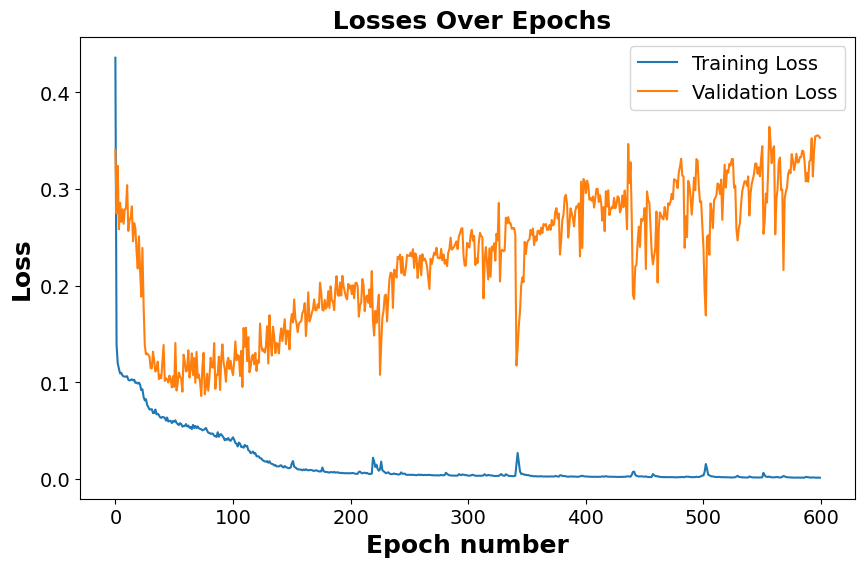

In [ ]:
# PRINT LOSS
import seaborn as sns
import matplotlib.pyplot as plt

# Print the average Loss Over Epochs during training and validation

print(len(train_losses))
print(len(val_losses))
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='Training Loss')

sns.lineplot(x=range(len(val_losses)), y=val_losses, label='Validation Loss')

plt.xlabel('Epoch number',fontsize=18, fontweight='bold')
plt.ylabel('Loss',fontsize=18, fontweight='bold')
plt.title(' Losses Over Epochs', fontsize=18, fontweight='bold')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xticks(rotation=0)
plt.show()



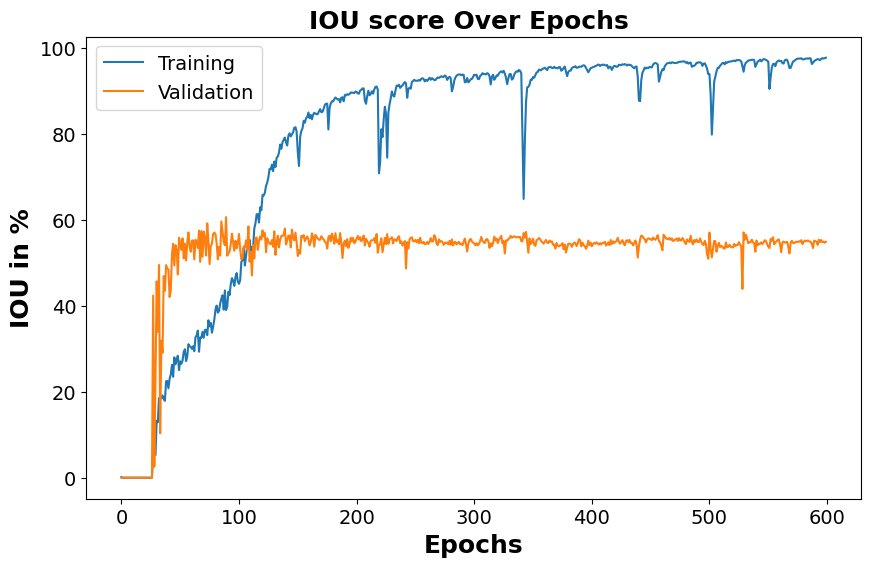

In [ ]:
# PRINT IOU score Over Epochs during training and validation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Plotting IOU scores
sns.lineplot(x=range(len(train_iou_record)), y=train_iou_record, label='Training')
sns.lineplot(x=range(len(val_iou_record)), y=val_iou_record, label='Validation')

plt.xlabel('Epochs', fontsize=18, fontweight='bold')  # Assuming x-axis represents epochs, adjust accordingly
plt.ylabel('IOU in %', fontsize=18, fontweight='bold')  # Adjust ylabel according to your data
plt.title('IOU score Over Epochs ', fontsize=18, fontweight='bold')  # Adjust the title as needed
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xticks(rotation=0)

plt.show()

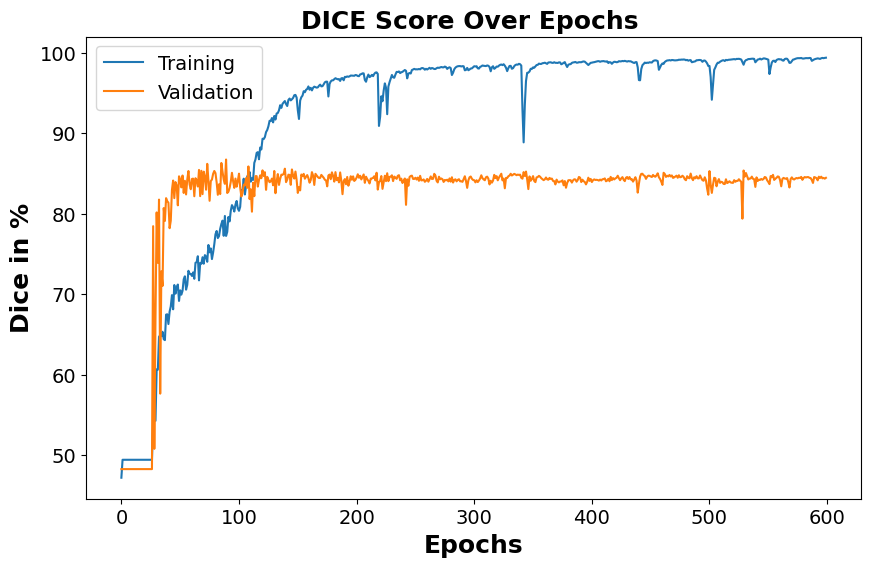

In [ ]:
# PRINT DICE score Over Epochs during training and validation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Plotting DICE scores
sns.lineplot(x=range(len(train_dice_record)), y=train_dice_record, label='Training')
sns.lineplot(x=range(len(val_dice_record)), y=val_dice_record, label='Validation')

plt.xlabel('Epochs', fontsize=18, fontweight='bold')  # Assuming x-axis represents epochs, adjust accordingly
plt.ylabel('Dice in %', fontsize=18, fontweight='bold')  # Adjust ylabel according to your data
plt.title('DICE Score Over Epochs ', fontsize=18, fontweight='bold')  # Adjust the title as needed
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xticks(rotation=0)

plt.show()

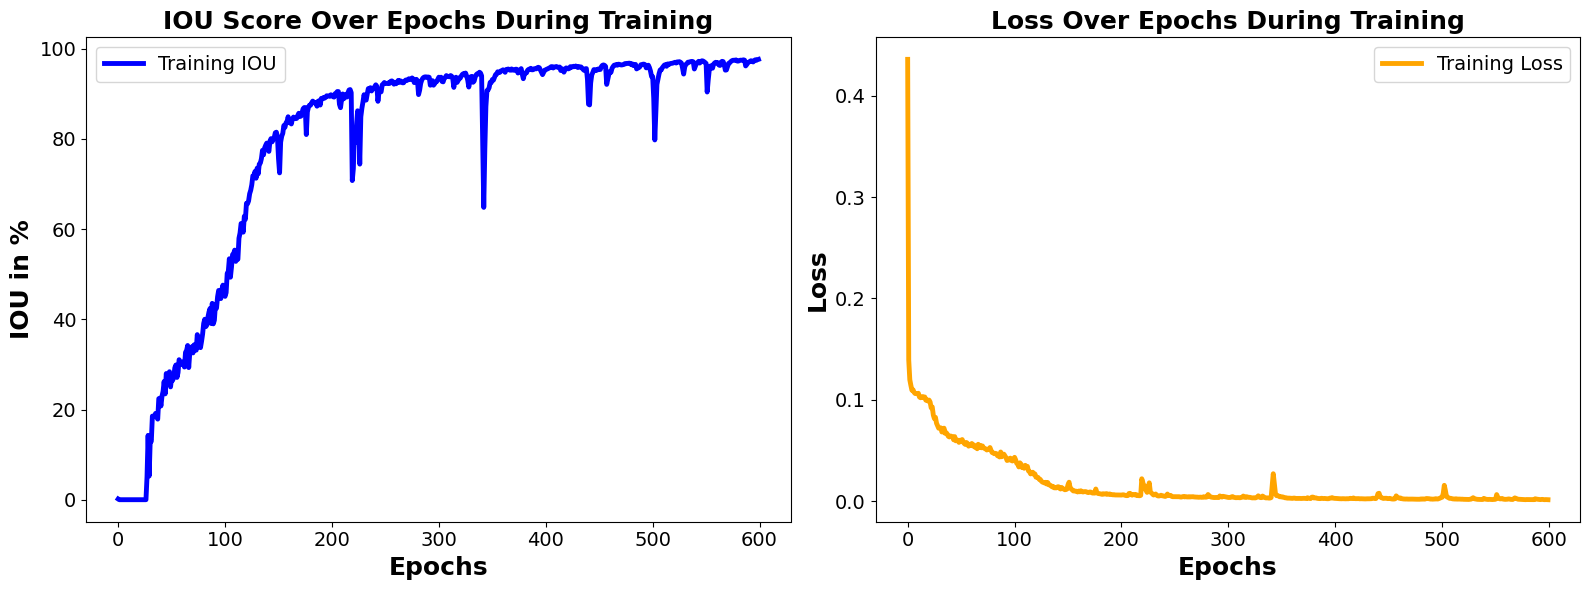

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting training IOU
sns.lineplot(x=range(len(train_iou_record)), y=train_iou_record, label='Training IOU', color='blue', ax=axs[0],  linewidth=3.5)
axs[0].set_xlabel('Epochs', fontsize=18, fontweight='bold')
axs[0].set_ylabel('IOU in %', fontsize=18, fontweight='bold')
axs[0].set_title('IOU Score Over Epochs During Training', fontsize=18, fontweight='bold')
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=14)

# Plotting training loss
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='Training Loss', color='orange', ax=axs[1],  linewidth=3.5)
axs[1].set_xlabel('Epochs', fontsize=18, fontweight='bold')
axs[1].set_ylabel('Loss', fontsize=18, fontweight='bold')
axs[1].set_title('Loss Over Epochs During Training', fontsize=18, fontweight='bold')
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
